# Importing

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [16]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [17]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [18]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [19]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [20]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)

    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters,' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 6673 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 7.17 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 21.0 g/kg
The mean salinity for cluster 0 is 15.85 g/kg 


The amount of grid boxes for cluster 1 is 7658 

The minimum temperature for cluster 1 is 6.42 degrees Celsius
The maximum temperature for cluster 1 is 9.37 degrees Celsius
The mean temperature for cluster 1 is 7.8 degrees Celsius 

The minimum salinity for cluster 1 is 23.92 g/kg
The maximum salinity for cluster 1 is 26.45 g/kg
The mean salinity for cluster 1 is 25.44 g/kg 


The amount of grid boxes for cluster 2 is 15483 

The minimum temperature for cluster 2 is 5.87 degrees Celsius
The maximum temperature for cluster 2 is 8.89 degrees Celsius
The mean temperature for cluster 2 is 7.83 degrees Celsius 

The min

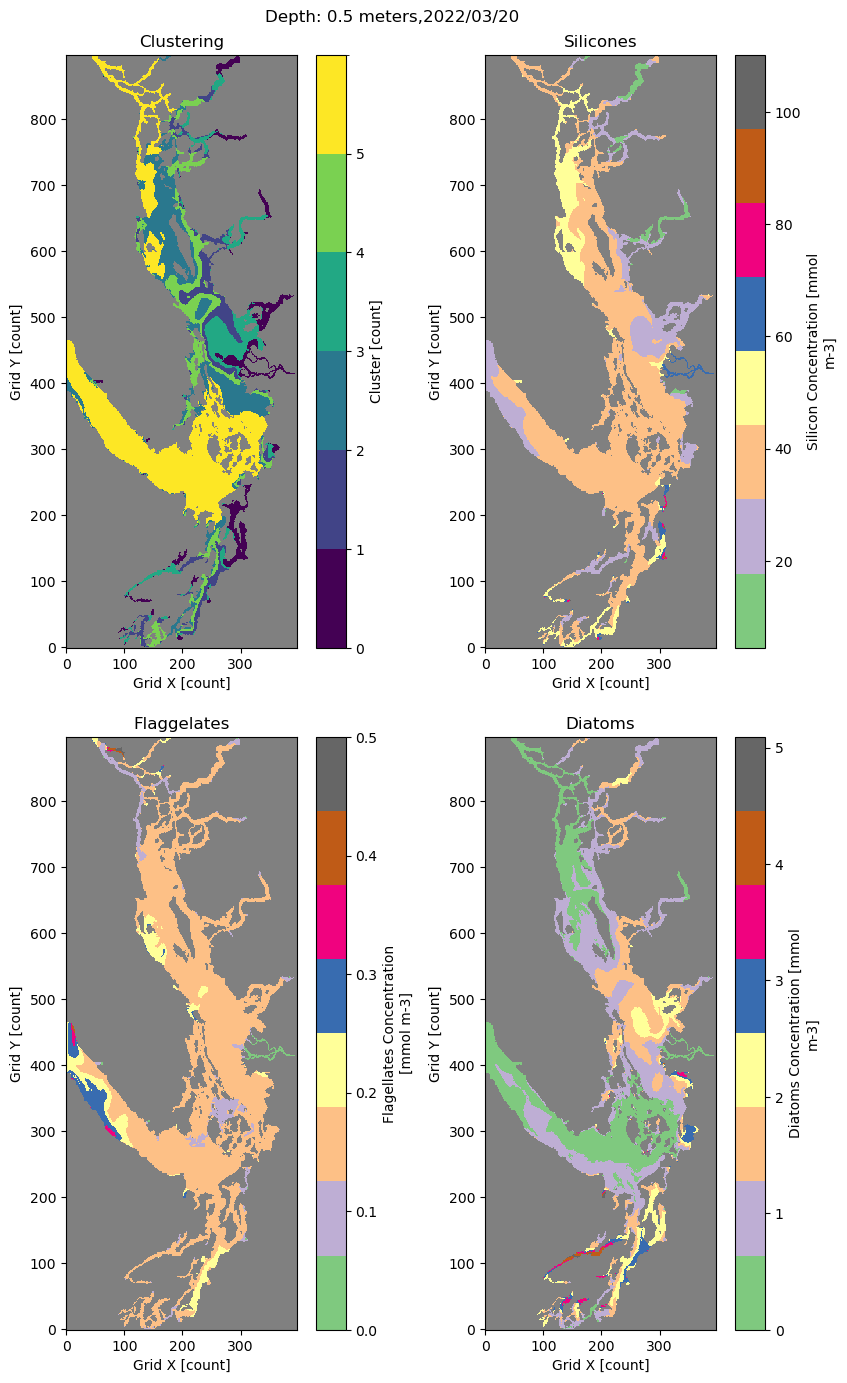

The amount of grid boxes for cluster 0 is 13347 

The minimum temperature for cluster 0 is 5.96 degrees Celsius
The maximum temperature for cluster 0 is 8.89 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 28.14 g/kg
The maximum salinity for cluster 0 is 29.03 g/kg
The mean salinity for cluster 0 is 28.62 g/kg 


The amount of grid boxes for cluster 1 is 9001 

The minimum temperature for cluster 1 is 6.38 degrees Celsius
The maximum temperature for cluster 1 is 9.92 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 25.3 g/kg
The maximum salinity for cluster 1 is 27.2 g/kg
The mean salinity for cluster 1 is 26.39 g/kg 


The amount of grid boxes for cluster 2 is 11380 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 9.82 degrees Celsius
The mean temperature for cluster 2 is 7.44 degrees Celsius 

The 

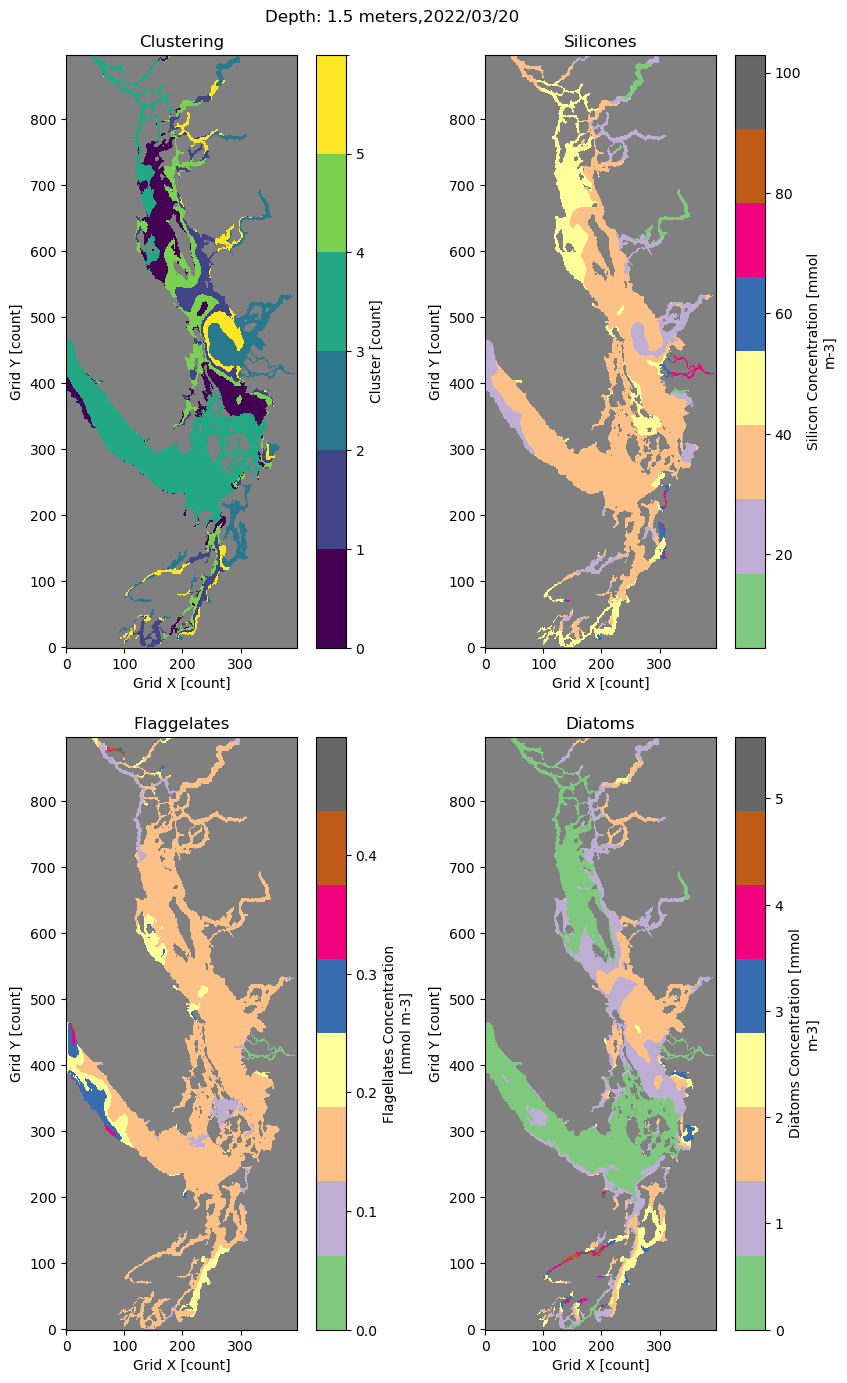

The amount of grid boxes for cluster 0 is 11007 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.81 degrees Celsius
The mean temperature for cluster 0 is 7.56 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 23.92 g/kg
The mean salinity for cluster 0 is 19.95 g/kg 


The amount of grid boxes for cluster 1 is 8779 

The minimum temperature for cluster 1 is 6.47 degrees Celsius
The maximum temperature for cluster 1 is 10.02 degrees Celsius
The mean temperature for cluster 1 is 7.84 degrees Celsius 

The minimum salinity for cluster 1 is 26.0 g/kg
The maximum salinity for cluster 1 is 27.41 g/kg
The mean salinity for cluster 1 is 26.76 g/kg 


The amount of grid boxes for cluster 2 is 12041 

The minimum temperature for cluster 2 is 5.93 degrees Celsius
The maximum temperature for cluster 2 is 8.54 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The m

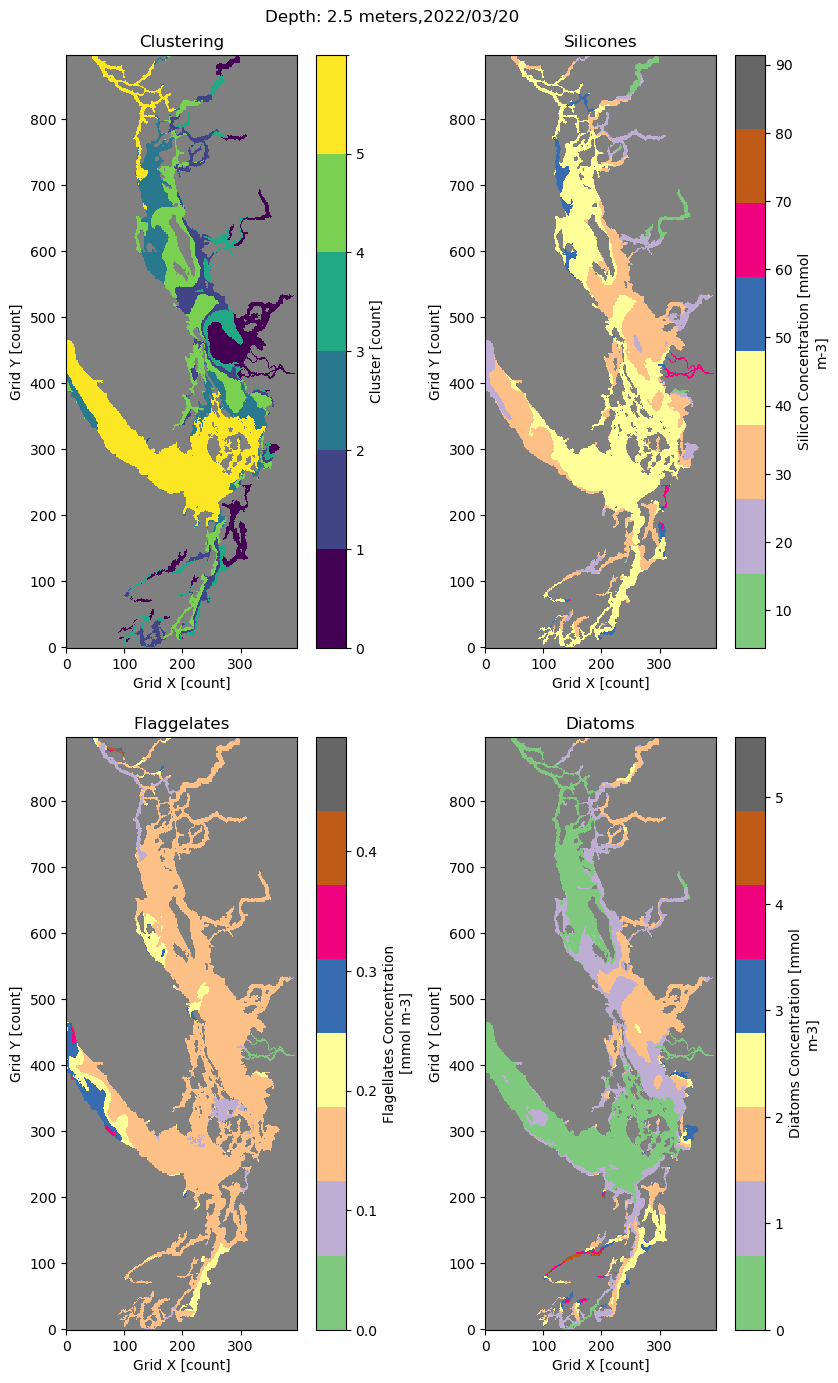

The amount of grid boxes for cluster 0 is 14124 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 10.03 degrees Celsius
The mean temperature for cluster 0 is 7.68 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.92 g/kg
The mean salinity for cluster 0 is 22.05 g/kg 


The amount of grid boxes for cluster 1 is 10040 

The minimum temperature for cluster 1 is 6.82 degrees Celsius
The maximum temperature for cluster 1 is 10.09 degrees Celsius
The mean temperature for cluster 1 is 7.78 degrees Celsius 

The minimum salinity for cluster 1 is 26.95 g/kg
The maximum salinity for cluster 1 is 28.07 g/kg
The mean salinity for cluster 1 is 27.6 g/kg 


The amount of grid boxes for cluster 2 is 8965 

The minimum temperature for cluster 2 is 5.88 degrees Celsius
The maximum temperature for cluster 2 is 8.31 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

The

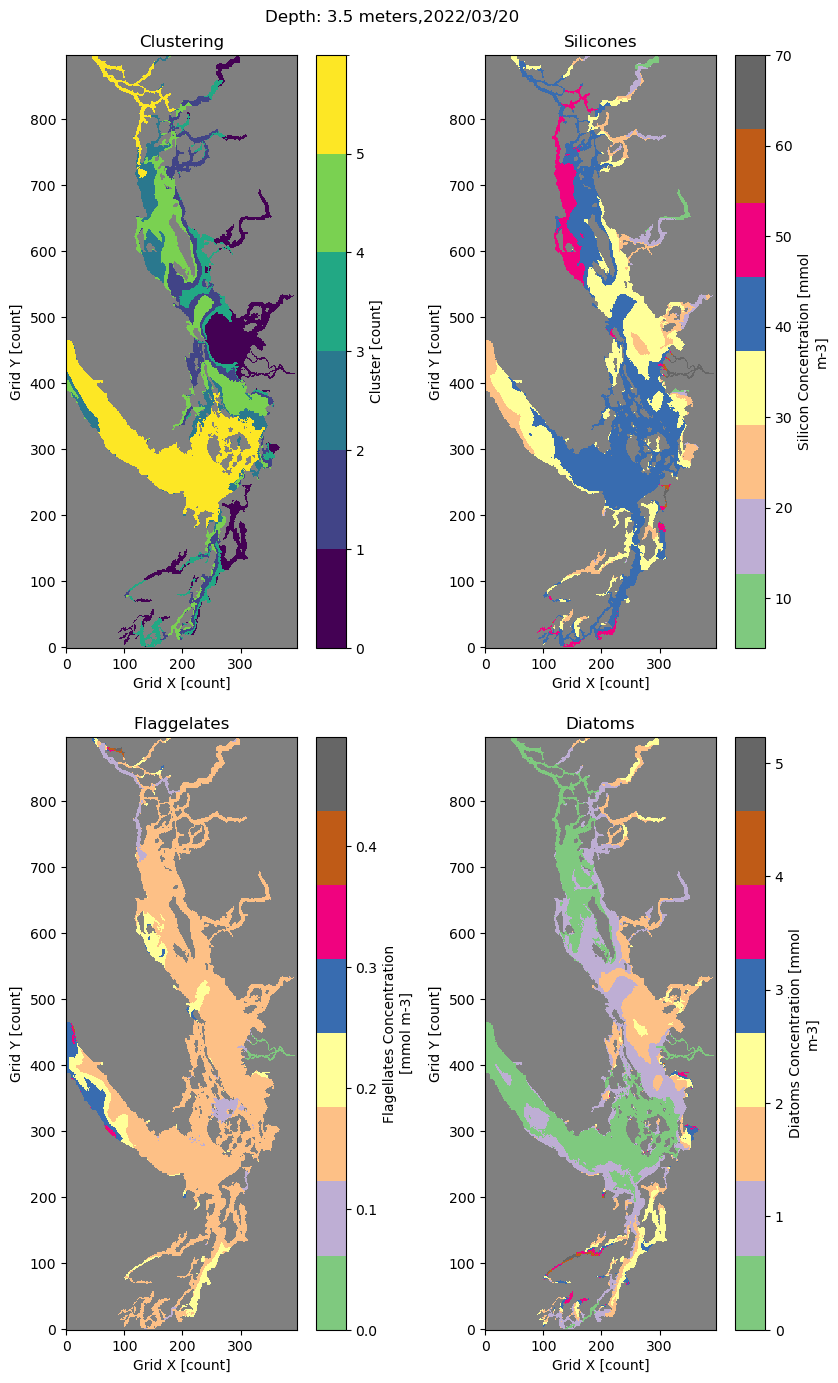

The amount of grid boxes for cluster 0 is 10015 

The minimum temperature for cluster 0 is 5.75 degrees Celsius
The maximum temperature for cluster 0 is 8.46 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 28.83 g/kg
The maximum salinity for cluster 0 is 29.5 g/kg
The mean salinity for cluster 0 is 29.12 g/kg 


The amount of grid boxes for cluster 1 is 10109 

The minimum temperature for cluster 1 is 6.51 degrees Celsius
The maximum temperature for cluster 1 is 10.18 degrees Celsius
The mean temperature for cluster 1 is 7.77 degrees Celsius 

The minimum salinity for cluster 1 is 26.67 g/kg
The maximum salinity for cluster 1 is 27.94 g/kg
The mean salinity for cluster 1 is 27.4 g/kg 


The amount of grid boxes for cluster 2 is 7870 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 9.31 degrees Celsius
The mean temperature for cluster 2 is 7.6 degrees Celsius 

The m

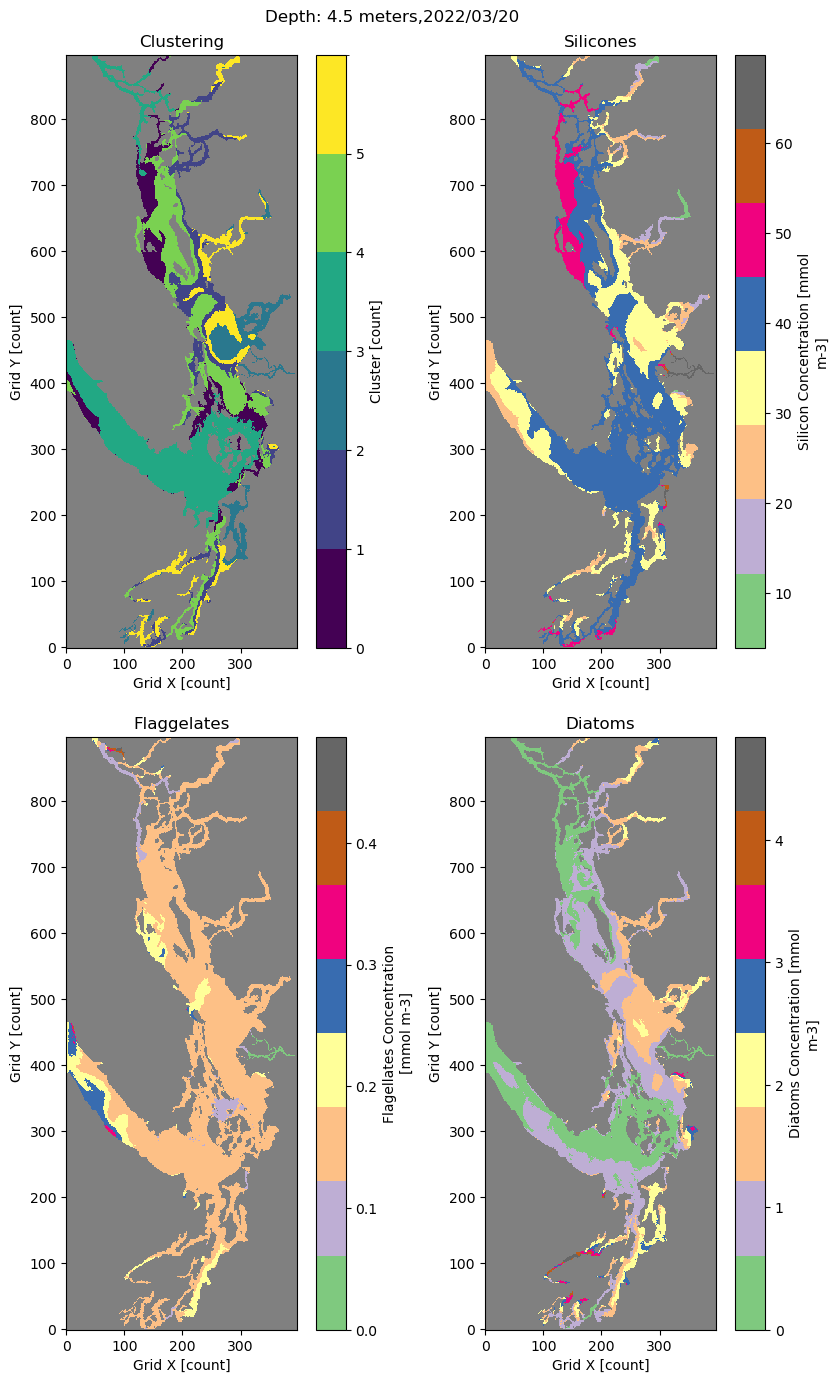

The amount of grid boxes for cluster 0 is 12292 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.33 degrees Celsius
The mean temperature for cluster 0 is 7.71 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.7 g/kg
The mean salinity for cluster 0 is 23.85 g/kg 


The amount of grid boxes for cluster 1 is 11837 

The minimum temperature for cluster 1 is 6.9 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 7.81 degrees Celsius 

The minimum salinity for cluster 1 is 27.54 g/kg
The maximum salinity for cluster 1 is 28.33 g/kg
The mean salinity for cluster 1 is 28.02 g/kg 


The amount of grid boxes for cluster 2 is 8200 

The minimum temperature for cluster 2 is 5.74 degrees Celsius
The maximum temperature for cluster 2 is 8.47 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The mi

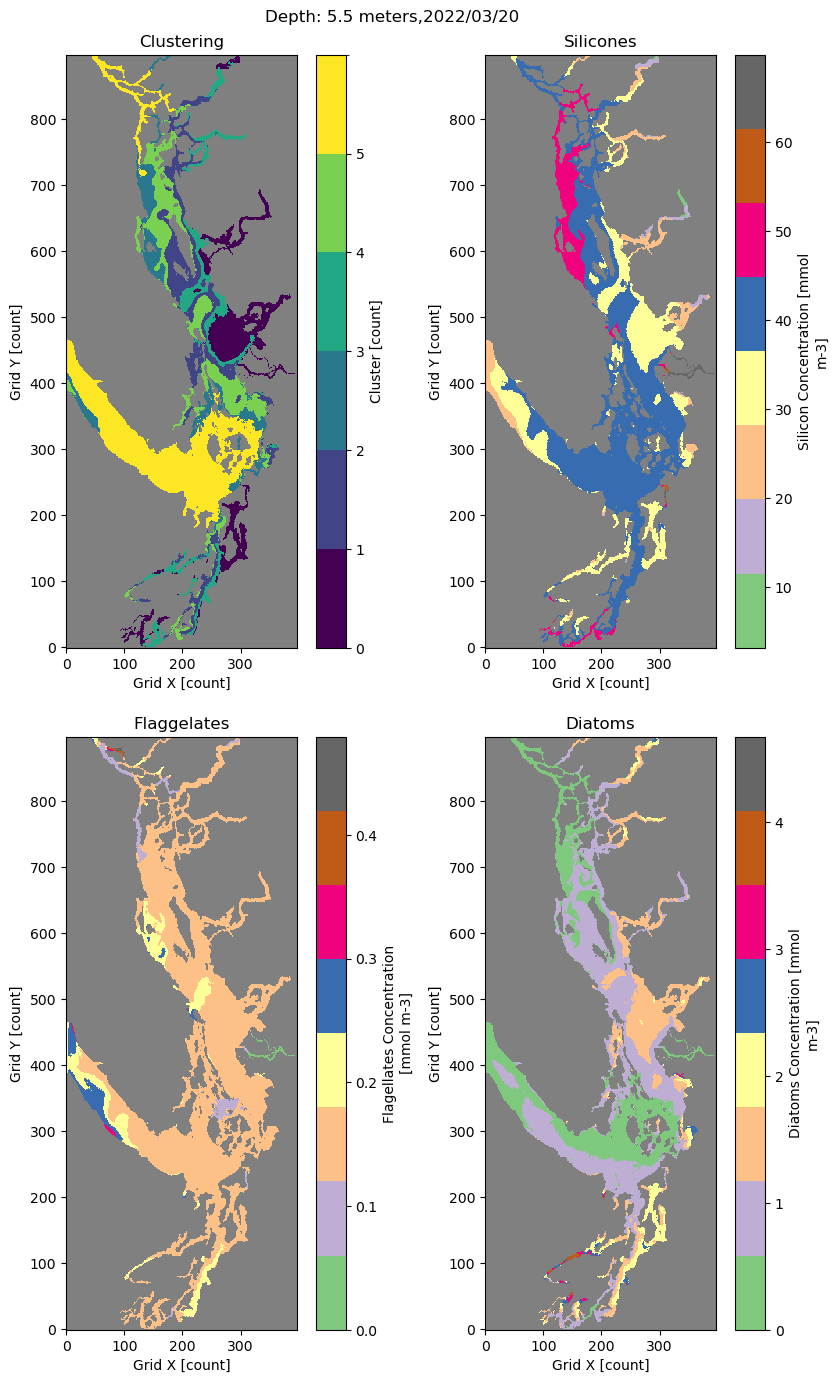

The amount of grid boxes for cluster 0 is 9139 

The minimum temperature for cluster 0 is 5.74 degrees Celsius
The maximum temperature for cluster 0 is 10.13 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 28.93 g/kg
The maximum salinity for cluster 0 is 29.59 g/kg
The mean salinity for cluster 0 is 29.22 g/kg 


The amount of grid boxes for cluster 1 is 14018 

The minimum temperature for cluster 1 is 7.02 degrees Celsius
The maximum temperature for cluster 1 is 10.24 degrees Celsius
The mean temperature for cluster 1 is 7.86 degrees Celsius 

The minimum salinity for cluster 1 is 27.86 g/kg
The maximum salinity for cluster 1 is 28.57 g/kg
The mean salinity for cluster 1 is 28.24 g/kg 


The amount of grid boxes for cluster 2 is 8971 

The minimum temperature for cluster 2 is 6.83 degrees Celsius
The maximum temperature for cluster 2 is 9.64 degrees Celsius
The mean temperature for cluster 2 is 7.83 degrees Celsius 

T

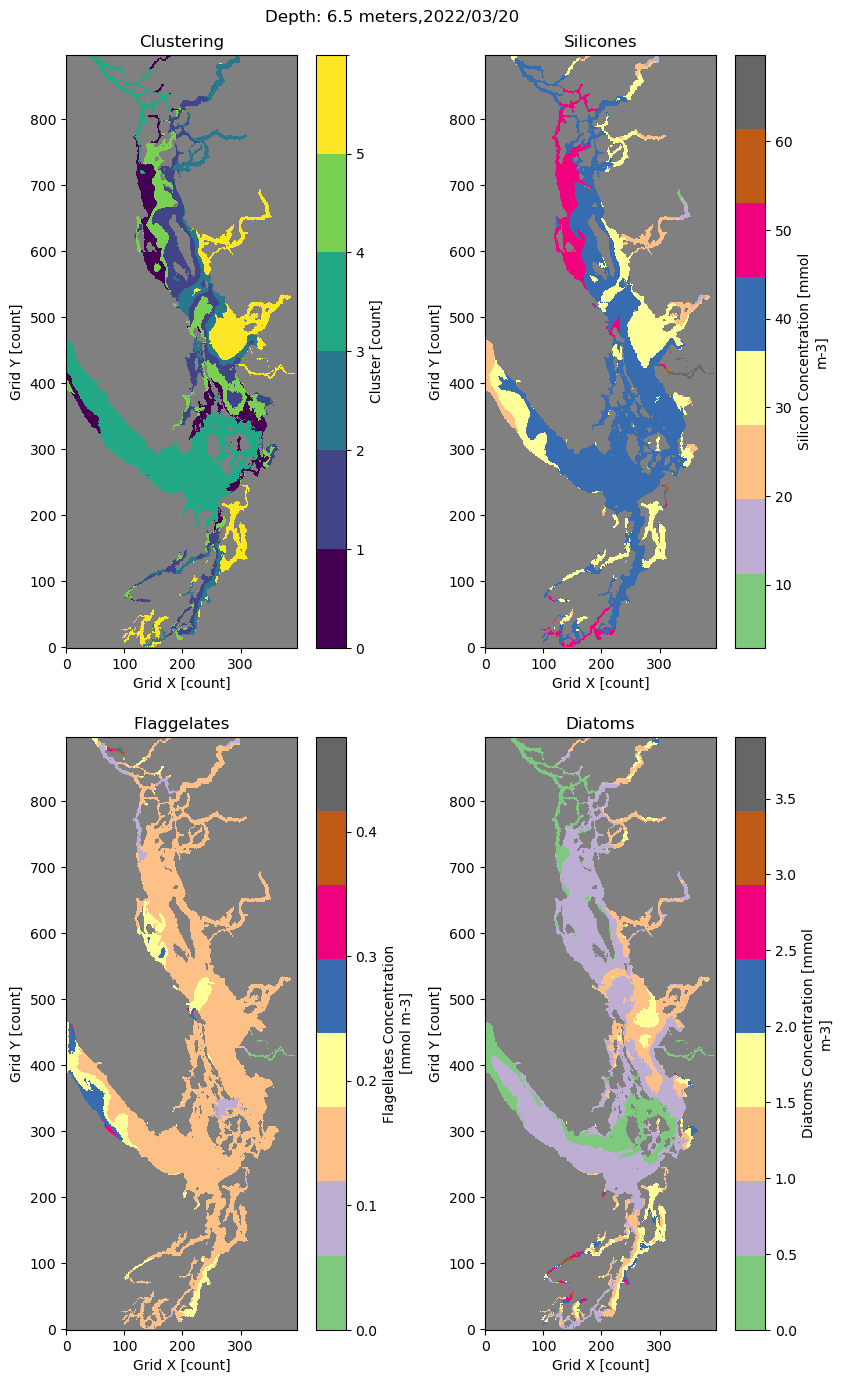

The amount of grid boxes for cluster 0 is 7086 

The minimum temperature for cluster 0 is 5.75 degrees Celsius
The maximum temperature for cluster 0 is 8.47 degrees Celsius
The mean temperature for cluster 0 is 7.83 degrees Celsius 

The minimum salinity for cluster 0 is 29.19 g/kg
The maximum salinity for cluster 0 is 29.74 g/kg
The mean salinity for cluster 0 is 29.46 g/kg 


The amount of grid boxes for cluster 1 is 16241 

The minimum temperature for cluster 1 is 7.11 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 27.93 g/kg
The maximum salinity for cluster 1 is 28.65 g/kg
The mean salinity for cluster 1 is 28.34 g/kg 


The amount of grid boxes for cluster 2 is 11117 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 9.19 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

T

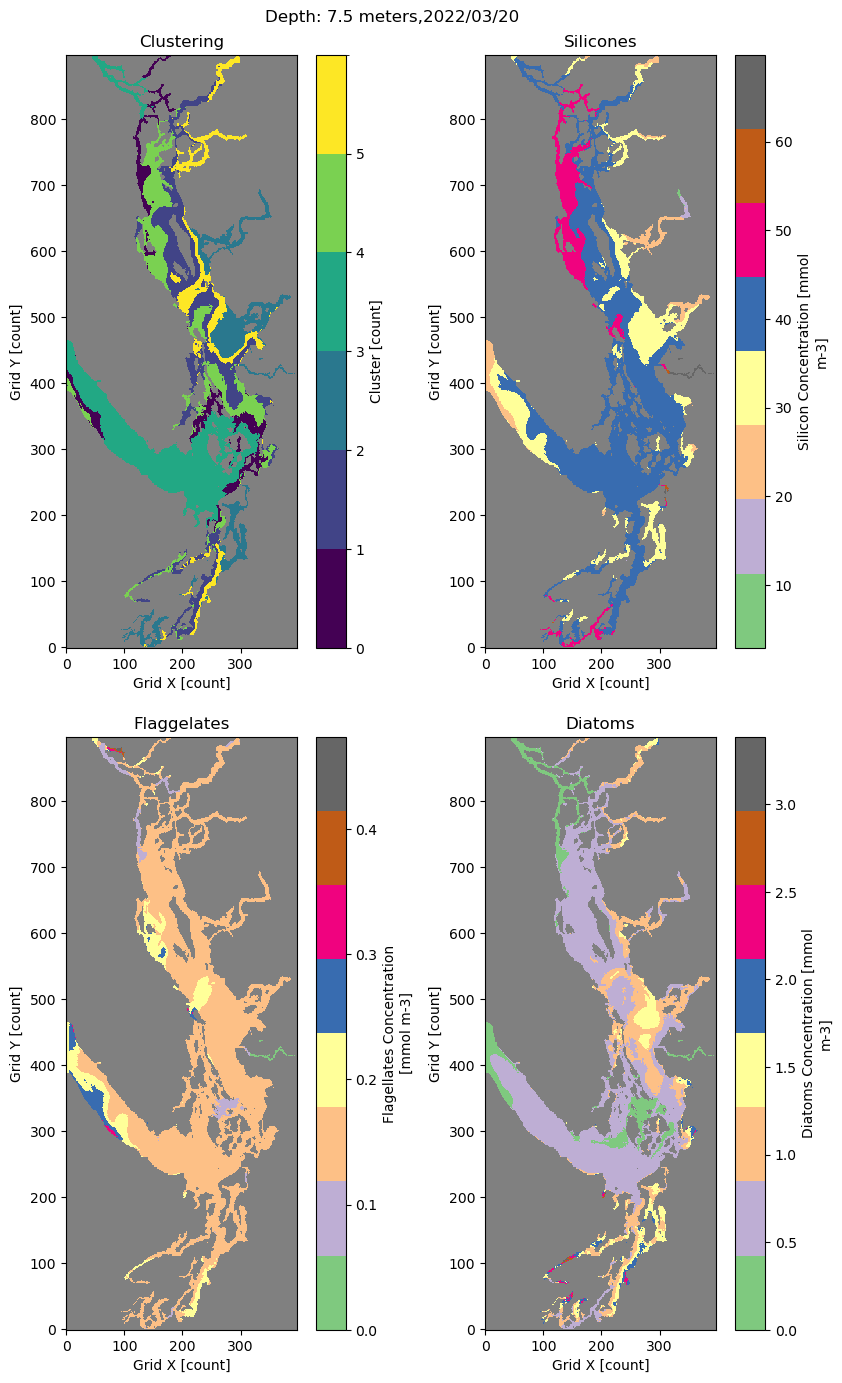

The amount of grid boxes for cluster 0 is 7781 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 10.13 degrees Celsius
The mean temperature for cluster 0 is 7.96 degrees Celsius 

The minimum salinity for cluster 0 is 29.02 g/kg
The maximum salinity for cluster 0 is 29.66 g/kg
The mean salinity for cluster 0 is 29.28 g/kg 


The amount of grid boxes for cluster 1 is 18553 

The minimum temperature for cluster 1 is 7.12 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 27.95 g/kg
The maximum salinity for cluster 1 is 29.1 g/kg
The mean salinity for cluster 1 is 28.37 g/kg 


The amount of grid boxes for cluster 2 is 9528 

The minimum temperature for cluster 2 is 7.07 degrees Celsius
The maximum temperature for cluster 2 is 9.4 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The

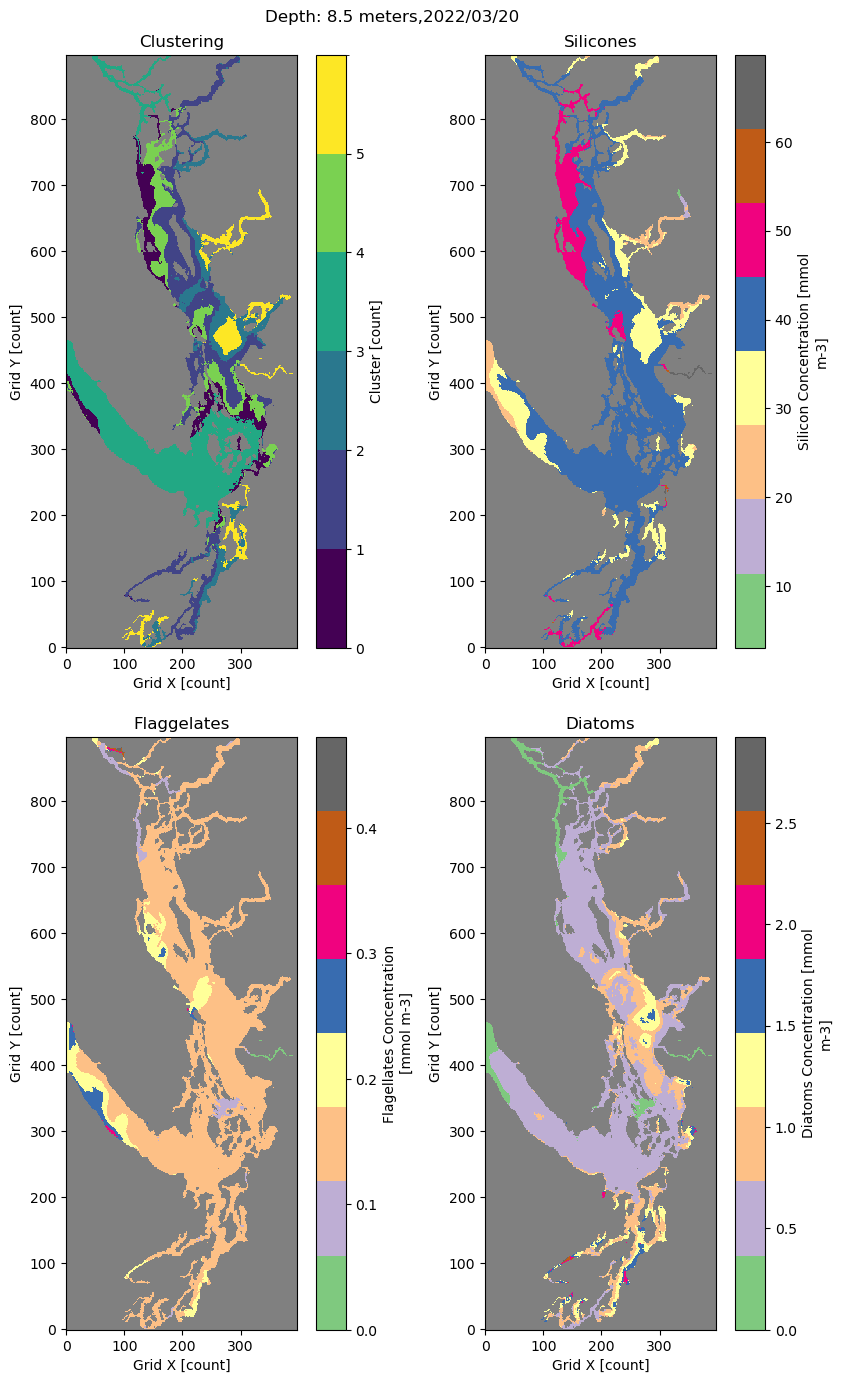

The amount of grid boxes for cluster 0 is 13241 

The minimum temperature for cluster 0 is 5.12 degrees Celsius
The maximum temperature for cluster 0 is 9.51 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.22 g/kg
The mean salinity for cluster 0 is 26.63 g/kg 


The amount of grid boxes for cluster 1 is 12992 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.22 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 28.19 g/kg
The maximum salinity for cluster 1 is 29.31 g/kg
The mean salinity for cluster 1 is 28.68 g/kg 


The amount of grid boxes for cluster 2 is 5430 

The minimum temperature for cluster 2 is 7.33 degrees Celsius
The maximum temperature for cluster 2 is 8.53 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The

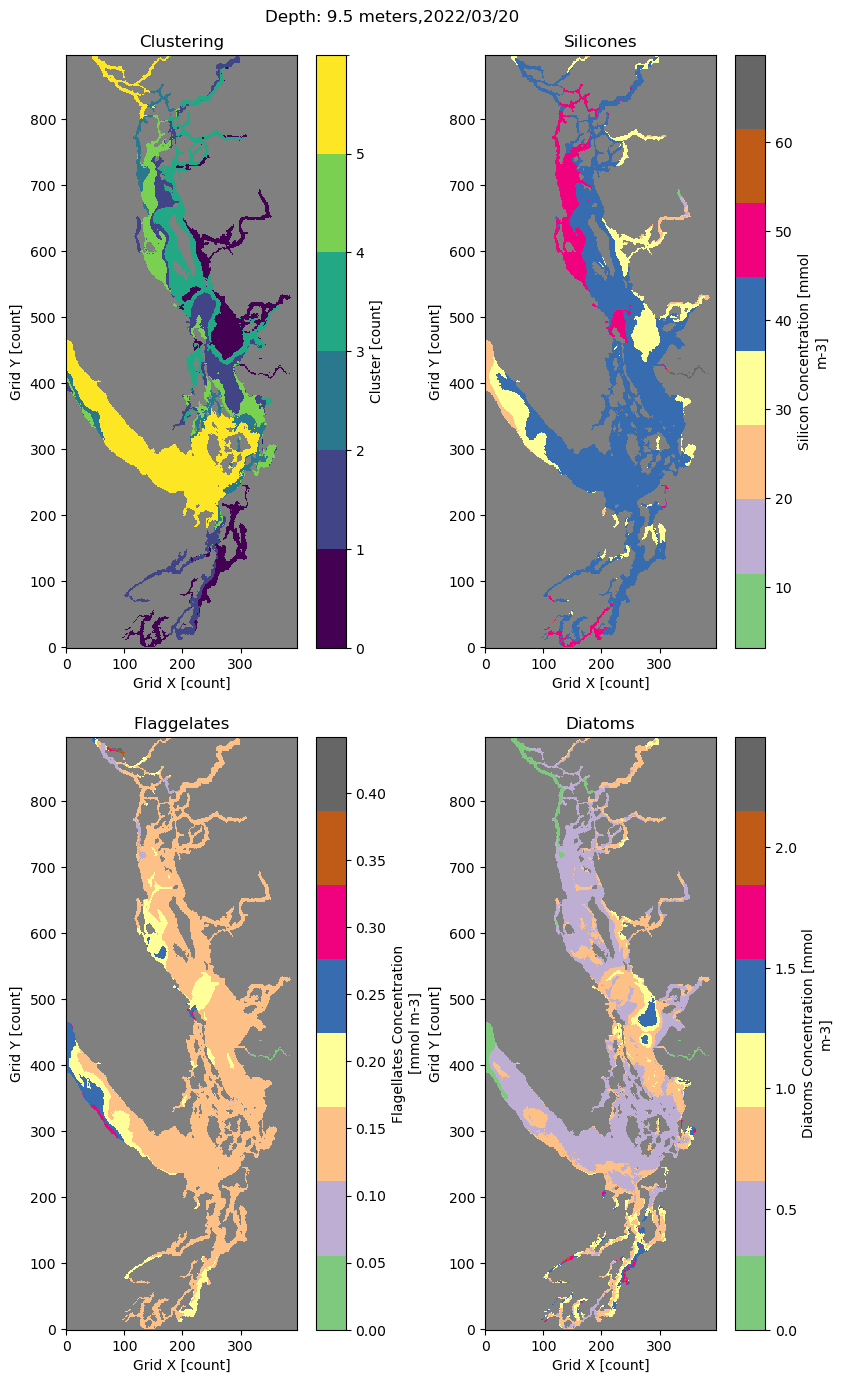

The amount of grid boxes for cluster 0 is 12692 

The minimum temperature for cluster 0 is 7.12 degrees Celsius
The maximum temperature for cluster 0 is 8.64 degrees Celsius
The mean temperature for cluster 0 is 7.61 degrees Celsius 

The minimum salinity for cluster 0 is 27.82 g/kg
The maximum salinity for cluster 0 is 28.58 g/kg
The mean salinity for cluster 0 is 28.22 g/kg 


The amount of grid boxes for cluster 1 is 10039 

The minimum temperature for cluster 1 is 5.77 degrees Celsius
The maximum temperature for cluster 1 is 8.53 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 28.8 g/kg
The maximum salinity for cluster 1 is 29.51 g/kg
The mean salinity for cluster 1 is 29.11 g/kg 


The amount of grid boxes for cluster 2 is 22345 

The minimum temperature for cluster 2 is 6.29 degrees Celsius
The maximum temperature for cluster 2 is 8.17 degrees Celsius
The mean temperature for cluster 2 is 7.69 degrees Celsius 

Th

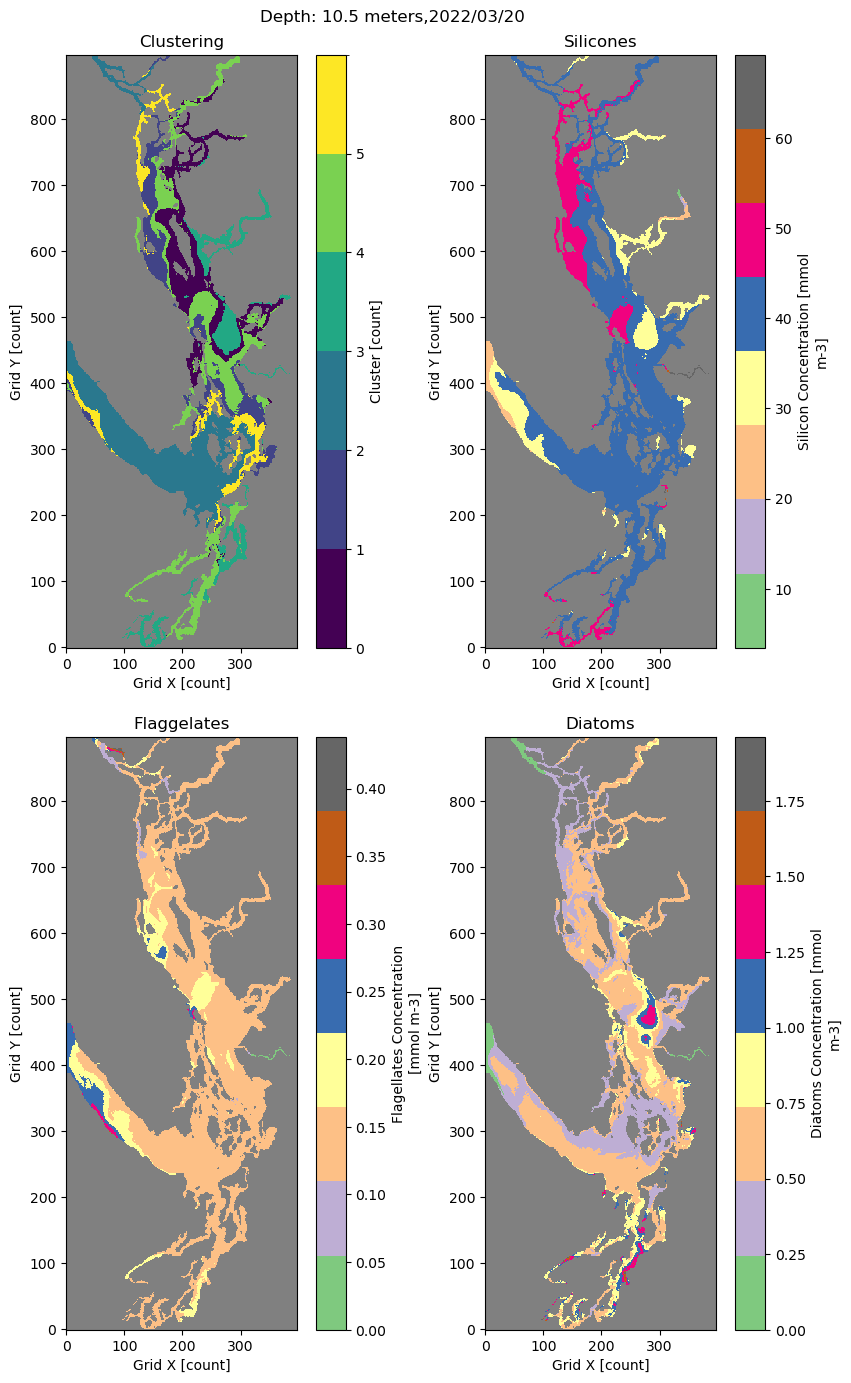

The amount of grid boxes for cluster 0 is 8457 

The minimum temperature for cluster 0 is 7.83 degrees Celsius
The maximum temperature for cluster 0 is 10.2 degrees Celsius
The mean temperature for cluster 0 is 8.62 degrees Celsius 

The minimum salinity for cluster 0 is 27.16 g/kg
The maximum salinity for cluster 0 is 29.36 g/kg
The mean salinity for cluster 0 is 28.46 g/kg 


The amount of grid boxes for cluster 1 is 7695 

The minimum temperature for cluster 1 is 7.47 degrees Celsius
The maximum temperature for cluster 1 is 10.14 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 29.02 g/kg
The maximum salinity for cluster 1 is 29.81 g/kg
The mean salinity for cluster 1 is 29.28 g/kg 


The amount of grid boxes for cluster 2 is 20387 

The minimum temperature for cluster 2 is 6.85 degrees Celsius
The maximum temperature for cluster 2 is 8.16 degrees Celsius
The mean temperature for cluster 2 is 7.69 degrees Celsius 

Th

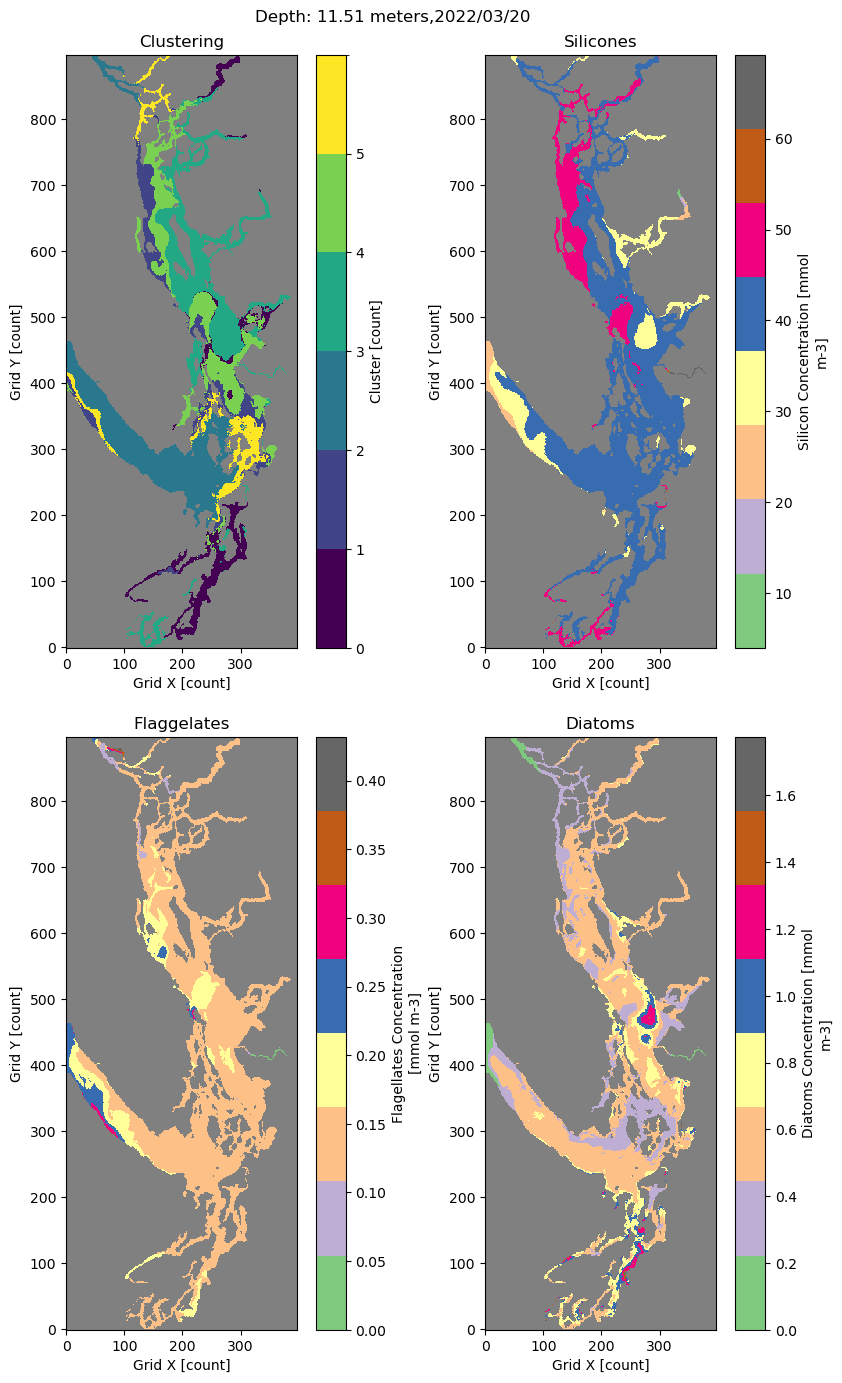

The amount of grid boxes for cluster 0 is 5999 

The minimum temperature for cluster 0 is 7.02 degrees Celsius
The maximum temperature for cluster 0 is 8.54 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.43 g/kg
The maximum salinity for cluster 0 is 29.98 g/kg
The mean salinity for cluster 0 is 29.67 g/kg 


The amount of grid boxes for cluster 1 is 12756 

The minimum temperature for cluster 1 is 7.69 degrees Celsius
The maximum temperature for cluster 1 is 10.15 degrees Celsius
The mean temperature for cluster 1 is 8.13 degrees Celsius 

The minimum salinity for cluster 1 is 28.82 g/kg
The maximum salinity for cluster 1 is 29.47 g/kg
The mean salinity for cluster 1 is 29.06 g/kg 


The amount of grid boxes for cluster 2 is 13111 

The minimum temperature for cluster 2 is 7.61 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.28 degrees Celsius 



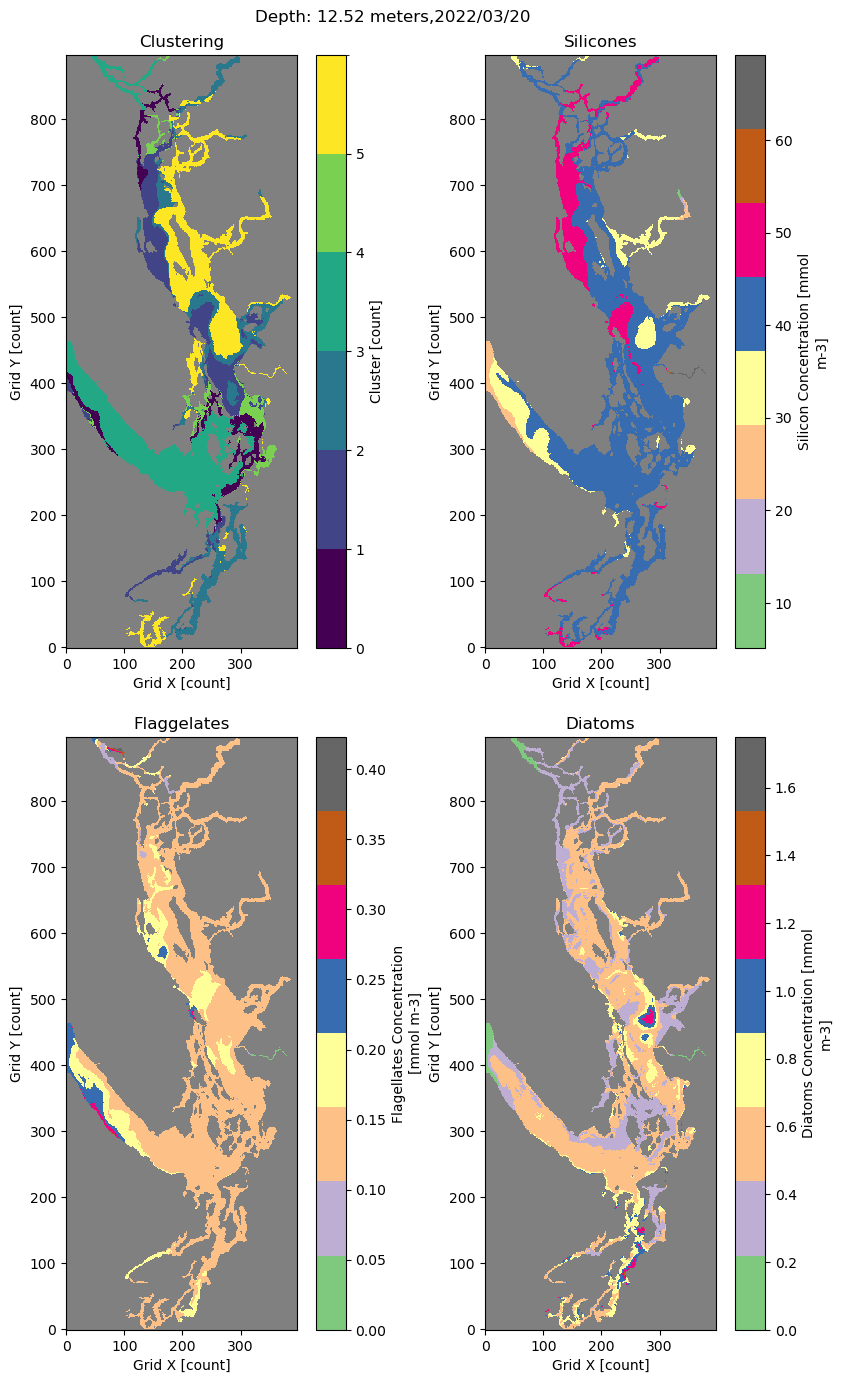

The amount of grid boxes for cluster 0 is 19925 

The minimum temperature for cluster 0 is 6.86 degrees Celsius
The maximum temperature for cluster 0 is 8.15 degrees Celsius
The mean temperature for cluster 0 is 7.68 degrees Celsius 

The minimum salinity for cluster 0 is 29.84 g/kg
The maximum salinity for cluster 0 is 31.33 g/kg
The mean salinity for cluster 0 is 30.46 g/kg 


The amount of grid boxes for cluster 1 is 4039 

The minimum temperature for cluster 1 is 5.87 degrees Celsius
The maximum temperature for cluster 1 is 8.23 degrees Celsius
The mean temperature for cluster 1 is 7.75 degrees Celsius 

The minimum salinity for cluster 1 is 28.85 g/kg
The maximum salinity for cluster 1 is 29.55 g/kg
The mean salinity for cluster 1 is 29.3 g/kg 


The amount of grid boxes for cluster 2 is 17061 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 9.19 degrees Celsius
The mean temperature for cluster 2 is 7.65 degrees Celsius 

The

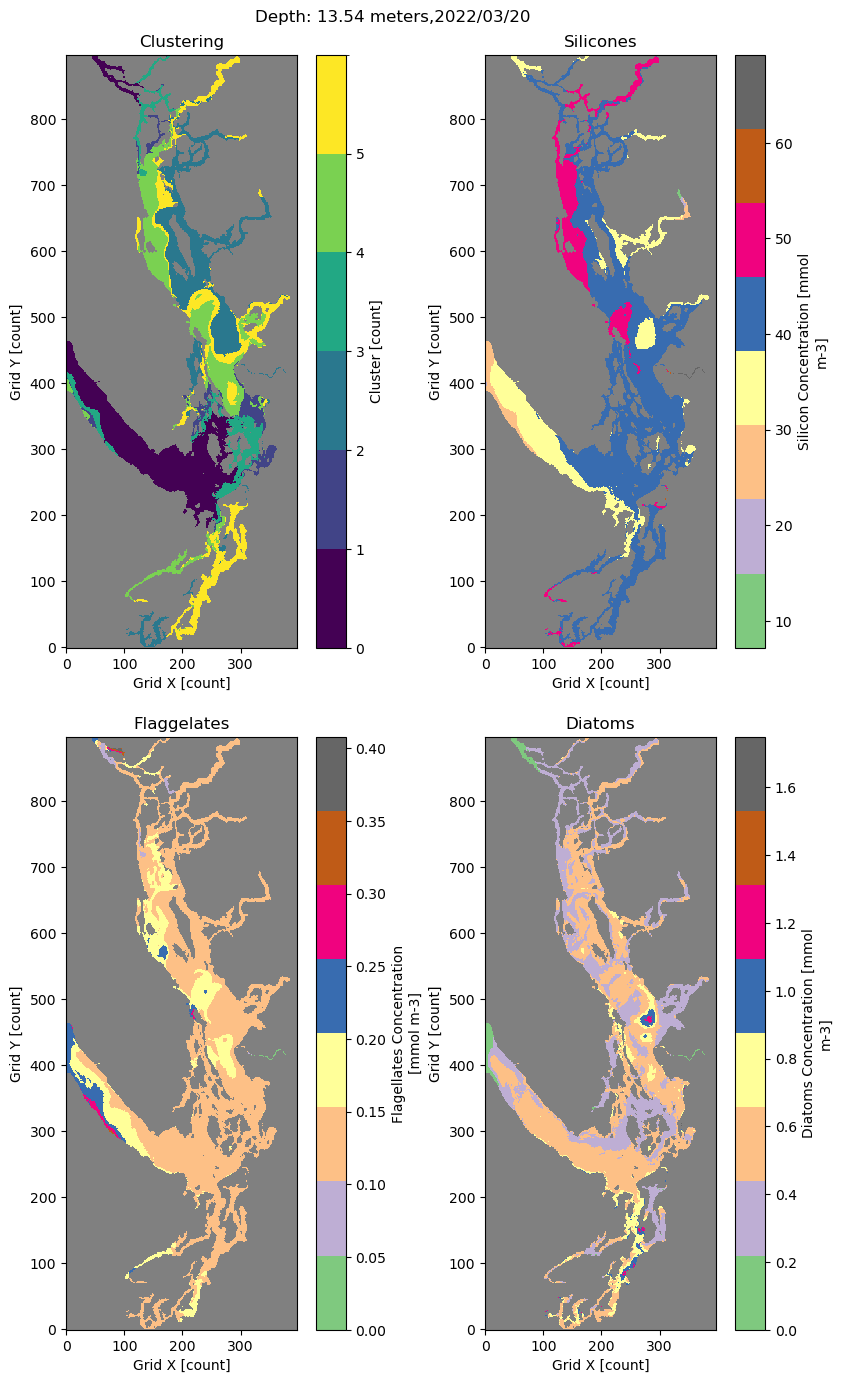

The amount of grid boxes for cluster 0 is 22304 

The minimum temperature for cluster 0 is 5.93 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.67 degrees Celsius 

The minimum salinity for cluster 0 is 29.51 g/kg
The maximum salinity for cluster 0 is 31.34 g/kg
The mean salinity for cluster 0 is 30.41 g/kg 


The amount of grid boxes for cluster 1 is 4432 

The minimum temperature for cluster 1 is 5.92 degrees Celsius
The maximum temperature for cluster 1 is 8.22 degrees Celsius
The mean temperature for cluster 1 is 7.79 degrees Celsius 

The minimum salinity for cluster 1 is 28.89 g/kg
The maximum salinity for cluster 1 is 29.56 g/kg
The mean salinity for cluster 1 is 29.3 g/kg 


The amount of grid boxes for cluster 2 is 13615 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 9.24 degrees Celsius
The mean temperature for cluster 2 is 7.63 degrees Celsius 

The

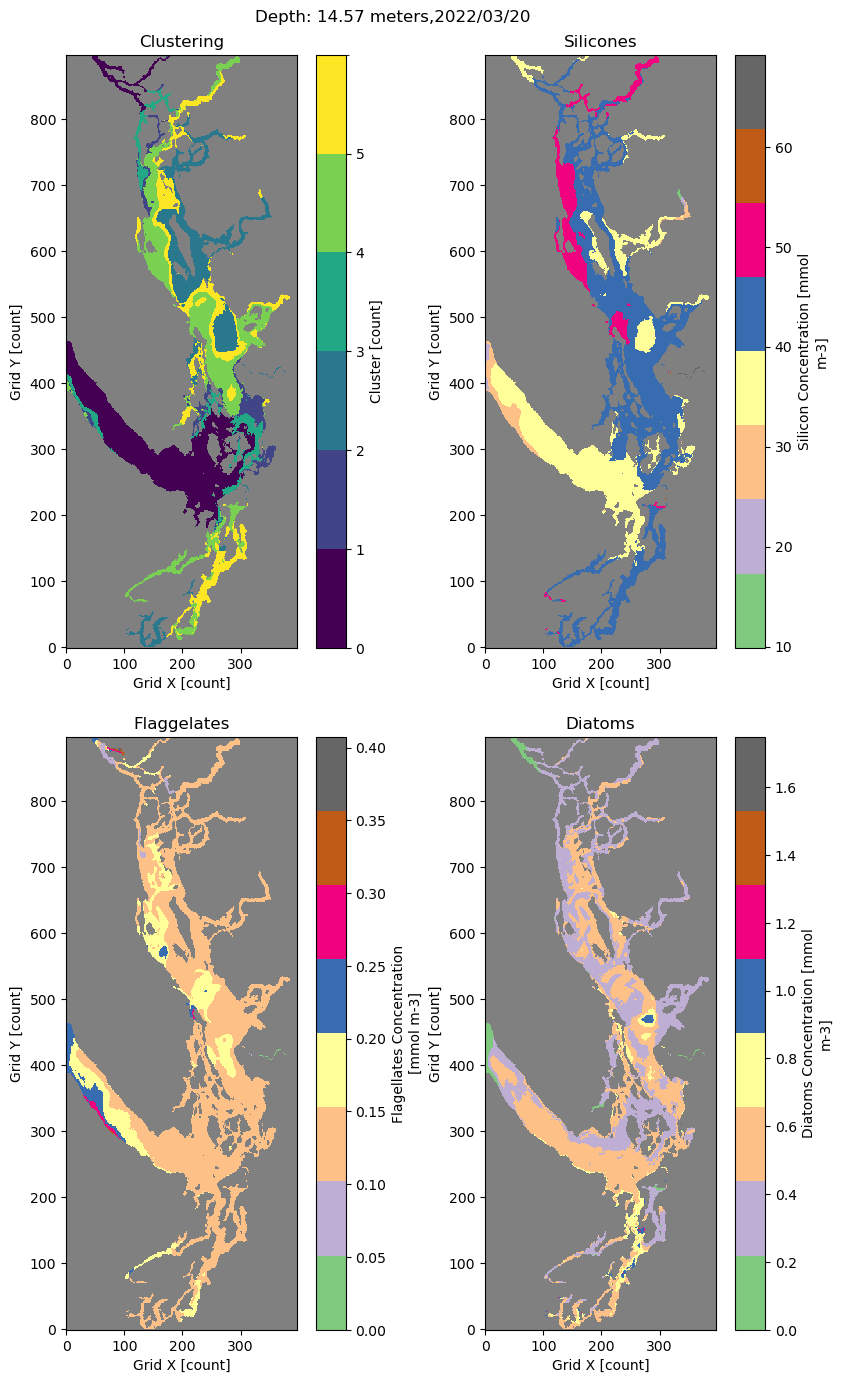

The amount of grid boxes for cluster 0 is 21301 

The minimum temperature for cluster 0 is 5.98 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.66 degrees Celsius 

The minimum salinity for cluster 0 is 29.53 g/kg
The maximum salinity for cluster 0 is 31.35 g/kg
The mean salinity for cluster 0 is 30.45 g/kg 


The amount of grid boxes for cluster 1 is 4900 

The minimum temperature for cluster 1 is 7.25 degrees Celsius
The maximum temperature for cluster 1 is 8.13 degrees Celsius
The mean temperature for cluster 1 is 7.76 degrees Celsius 

The minimum salinity for cluster 1 is 28.97 g/kg
The maximum salinity for cluster 1 is 29.65 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 16646 

The minimum temperature for cluster 2 is 5.12 degrees Celsius
The maximum temperature for cluster 2 is 8.6 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The

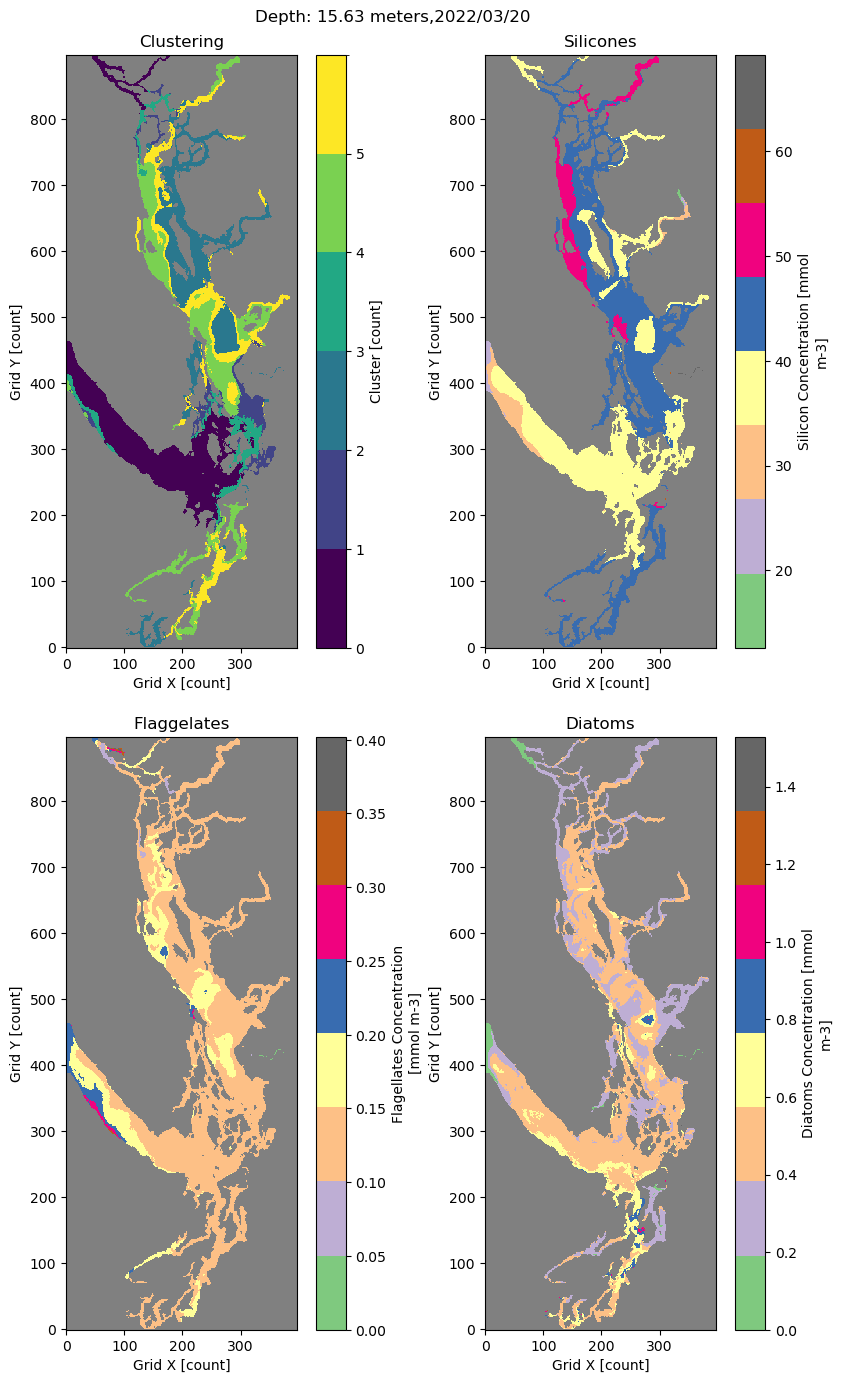

The amount of grid boxes for cluster 0 is 13744 

The minimum temperature for cluster 0 is 7.72 degrees Celsius
The maximum temperature for cluster 0 is 10.41 degrees Celsius
The mean temperature for cluster 0 is 8.3 degrees Celsius 

The minimum salinity for cluster 0 is 27.79 g/kg
The maximum salinity for cluster 0 is 29.18 g/kg
The mean salinity for cluster 0 is 28.92 g/kg 


The amount of grid boxes for cluster 1 is 10542 

The minimum temperature for cluster 1 is 7.77 degrees Celsius
The maximum temperature for cluster 1 is 10.18 degrees Celsius
The mean temperature for cluster 1 is 8.36 degrees Celsius 

The minimum salinity for cluster 1 is 28.88 g/kg
The maximum salinity for cluster 1 is 29.82 g/kg
The mean salinity for cluster 1 is 29.28 g/kg 


The amount of grid boxes for cluster 2 is 5086 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 8.13 degrees Celsius
The mean temperature for cluster 2 is 7.74 degrees Celsius 

T

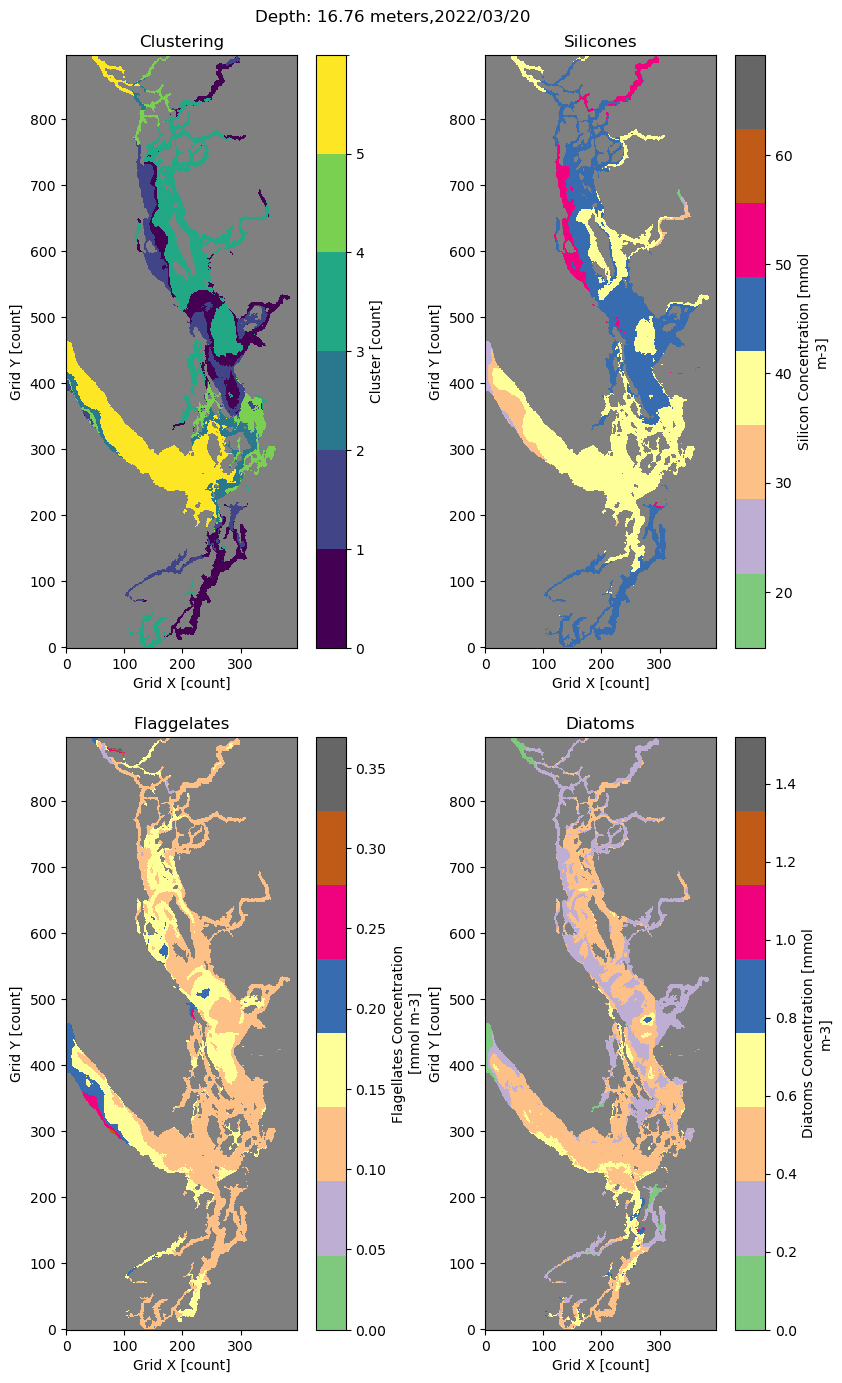

The amount of grid boxes for cluster 0 is 20613 

The minimum temperature for cluster 0 is 5.13 degrees Celsius
The maximum temperature for cluster 0 is 8.55 degrees Celsius
The mean temperature for cluster 0 is 7.74 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.11 g/kg
The mean salinity for cluster 0 is 28.5 g/kg 


The amount of grid boxes for cluster 1 is 5298 

The minimum temperature for cluster 1 is 6.16 degrees Celsius
The maximum temperature for cluster 1 is 8.12 degrees Celsius
The mean temperature for cluster 1 is 7.72 degrees Celsius 

The minimum salinity for cluster 1 is 29.09 g/kg
The maximum salinity for cluster 1 is 29.78 g/kg
The mean salinity for cluster 1 is 29.53 g/kg 


The amount of grid boxes for cluster 2 is 17434 

The minimum temperature for cluster 2 is 6.88 degrees Celsius
The maximum temperature for cluster 2 is 8.11 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The m

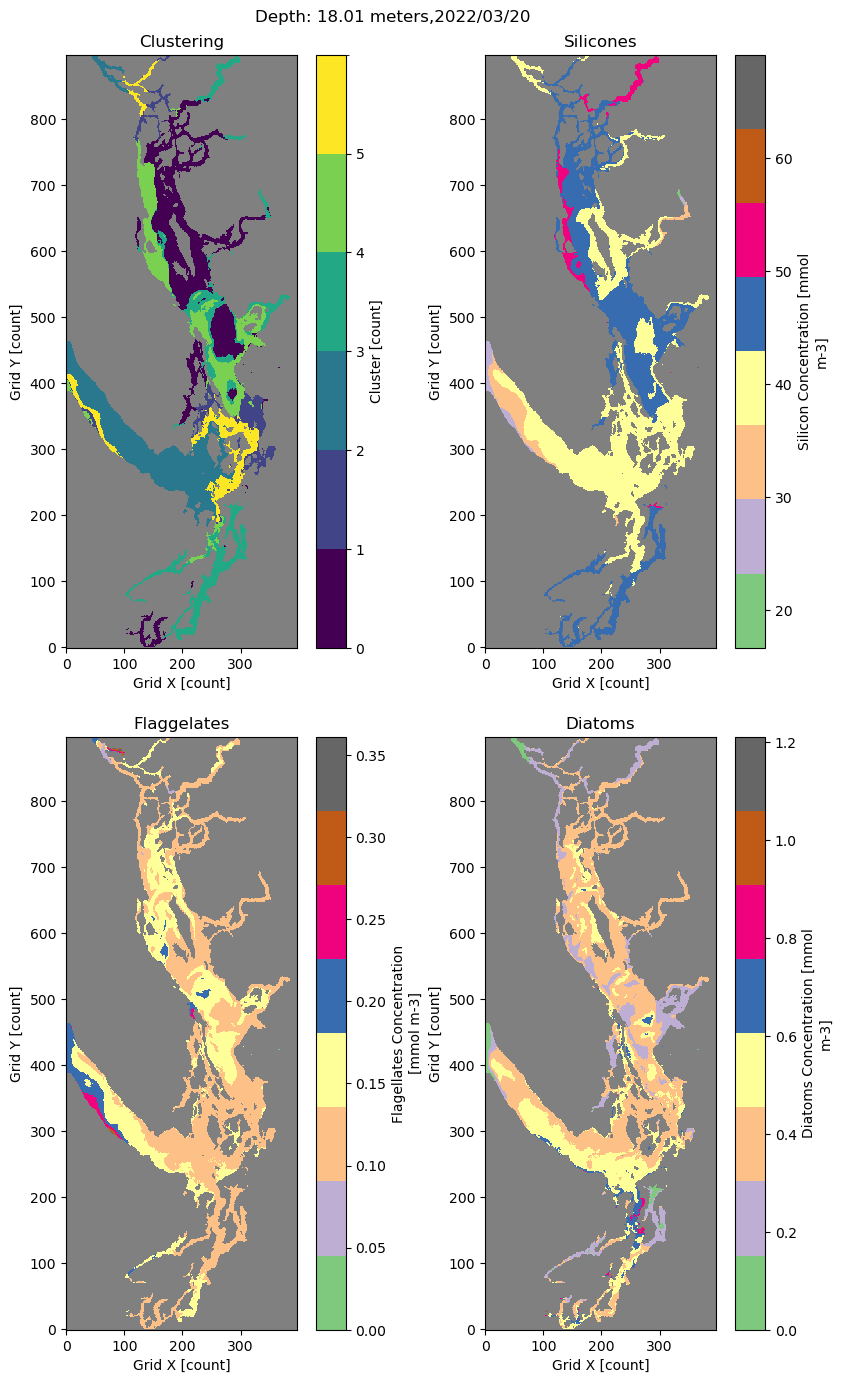

The amount of grid boxes for cluster 0 is 20784 

The minimum temperature for cluster 0 is 5.17 degrees Celsius
The maximum temperature for cluster 0 is 8.59 degrees Celsius
The mean temperature for cluster 0 is 7.78 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.17 g/kg
The mean salinity for cluster 0 is 28.59 g/kg 


The amount of grid boxes for cluster 1 is 5277 

The minimum temperature for cluster 1 is 7.2 degrees Celsius
The maximum temperature for cluster 1 is 8.13 degrees Celsius
The mean temperature for cluster 1 is 7.74 degrees Celsius 

The minimum salinity for cluster 1 is 29.14 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 29.57 g/kg 


The amount of grid boxes for cluster 2 is 17109 

The minimum temperature for cluster 2 is 6.89 degrees Celsius
The maximum temperature for cluster 2 is 8.09 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The m

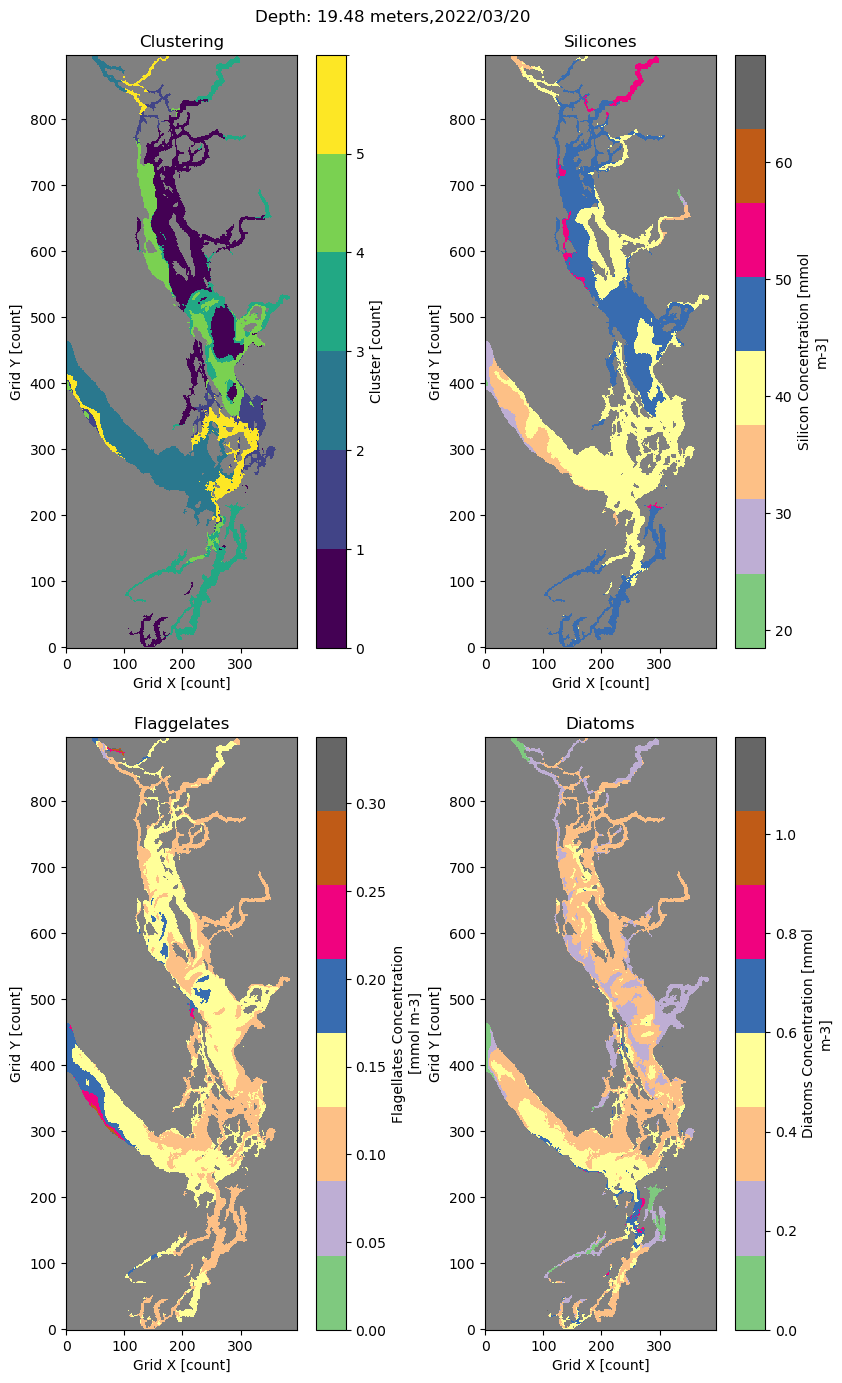

The amount of grid boxes for cluster 0 is 6113 

The minimum temperature for cluster 0 is 6.51 degrees Celsius
The maximum temperature for cluster 0 is 8.05 degrees Celsius
The mean temperature for cluster 0 is 7.66 degrees Celsius 

The minimum salinity for cluster 0 is 29.69 g/kg
The maximum salinity for cluster 0 is 30.33 g/kg
The mean salinity for cluster 0 is 30.08 g/kg 


The amount of grid boxes for cluster 1 is 5535 

The minimum temperature for cluster 1 is 7.2 degrees Celsius
The maximum temperature for cluster 1 is 8.22 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.7 g/kg
The mean salinity for cluster 1 is 29.43 g/kg 


The amount of grid boxes for cluster 2 is 20080 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.6 degrees Celsius
The mean temperature for cluster 2 is 7.82 degrees Celsius 

The mi

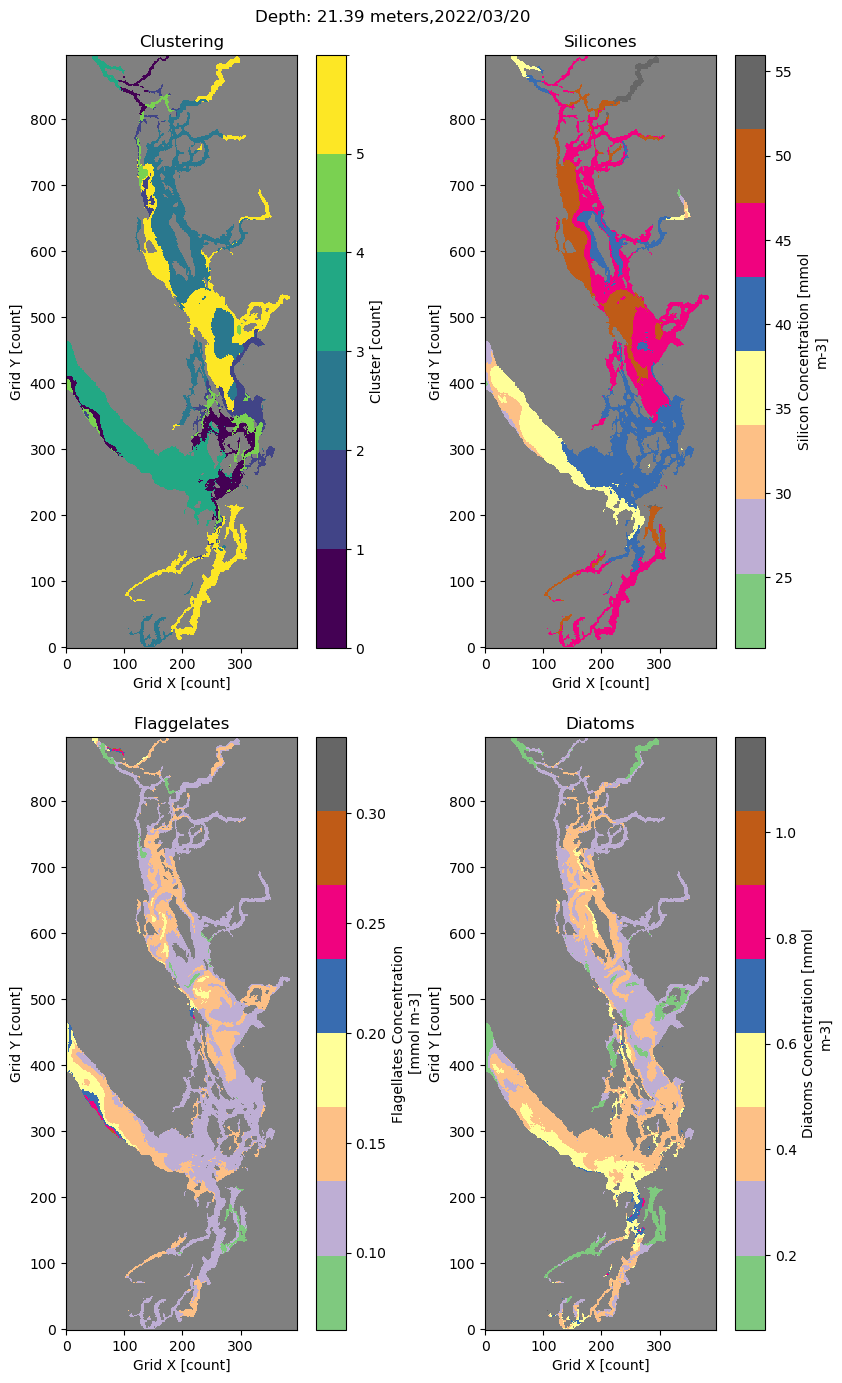

The amount of grid boxes for cluster 0 is 18646 

The minimum temperature for cluster 0 is 8.07 degrees Celsius
The maximum temperature for cluster 0 is 10.78 degrees Celsius
The mean temperature for cluster 0 is 8.6 degrees Celsius 

The minimum salinity for cluster 0 is 28.04 g/kg
The maximum salinity for cluster 0 is 29.72 g/kg
The mean salinity for cluster 0 is 29.29 g/kg 


The amount of grid boxes for cluster 1 is 3939 

The minimum temperature for cluster 1 is 7.85 degrees Celsius
The maximum temperature for cluster 1 is 8.56 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 29.35 g/kg
The maximum salinity for cluster 1 is 29.94 g/kg
The mean salinity for cluster 1 is 29.51 g/kg 


The amount of grid boxes for cluster 2 is 5181 

The minimum temperature for cluster 2 is 7.11 degrees Celsius
The maximum temperature for cluster 2 is 8.06 degrees Celsius
The mean temperature for cluster 2 is 7.69 degrees Celsius 

The

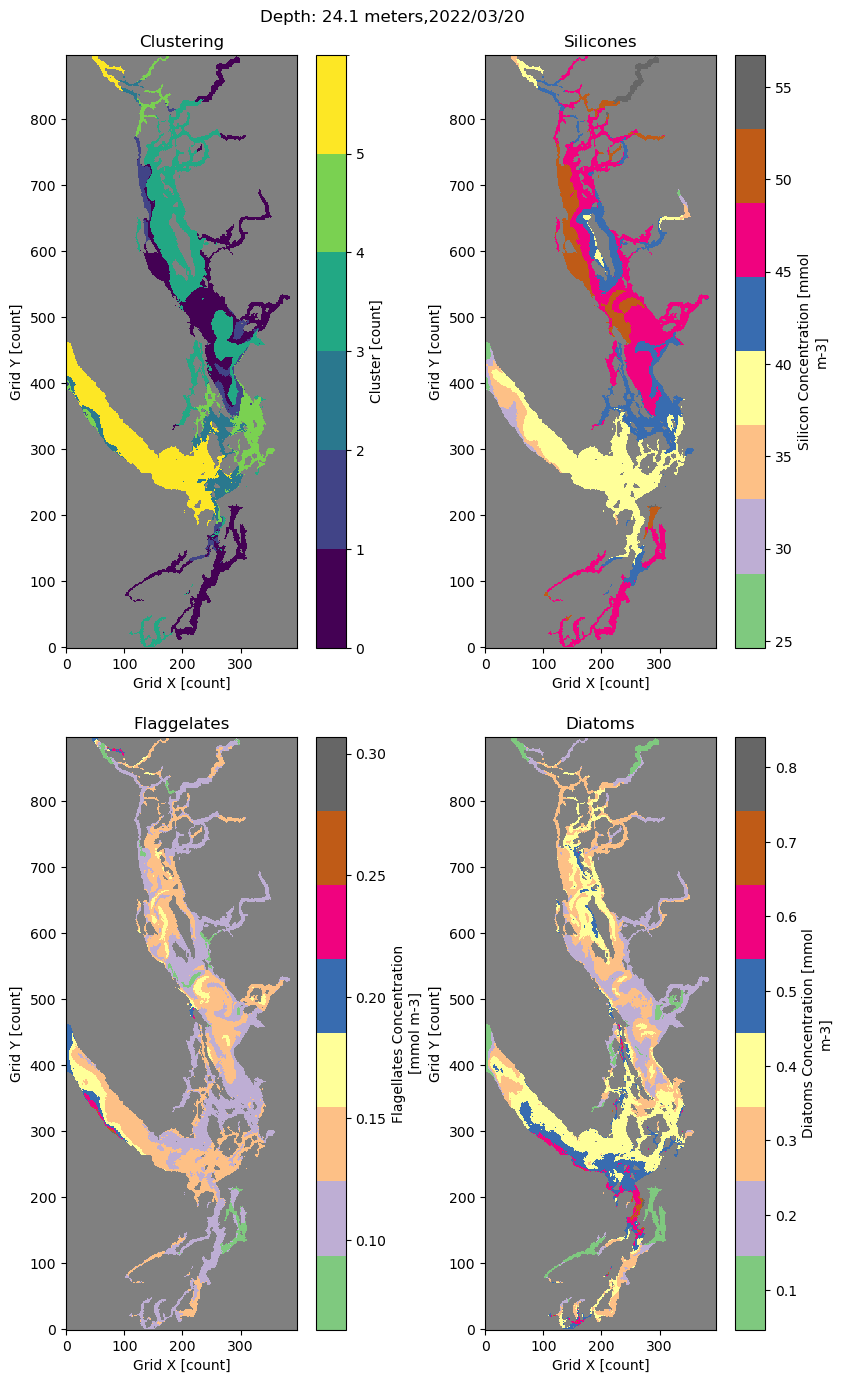

The amount of grid boxes for cluster 0 is 20037 

The minimum temperature for cluster 0 is 8.12 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 28.68 g/kg
The maximum salinity for cluster 0 is 29.79 g/kg
The mean salinity for cluster 0 is 29.44 g/kg 


The amount of grid boxes for cluster 1 is 3602 

The minimum temperature for cluster 1 is 7.85 degrees Celsius
The maximum temperature for cluster 1 is 8.57 degrees Celsius
The mean temperature for cluster 1 is 8.15 degrees Celsius 

The minimum salinity for cluster 1 is 29.43 g/kg
The maximum salinity for cluster 1 is 29.87 g/kg
The mean salinity for cluster 1 is 29.58 g/kg 


The amount of grid boxes for cluster 2 is 4586 

The minimum temperature for cluster 2 is 7.22 degrees Celsius
The maximum temperature for cluster 2 is 8.06 degrees Celsius
The mean temperature for cluster 2 is 7.68 degrees Celsius 

Th

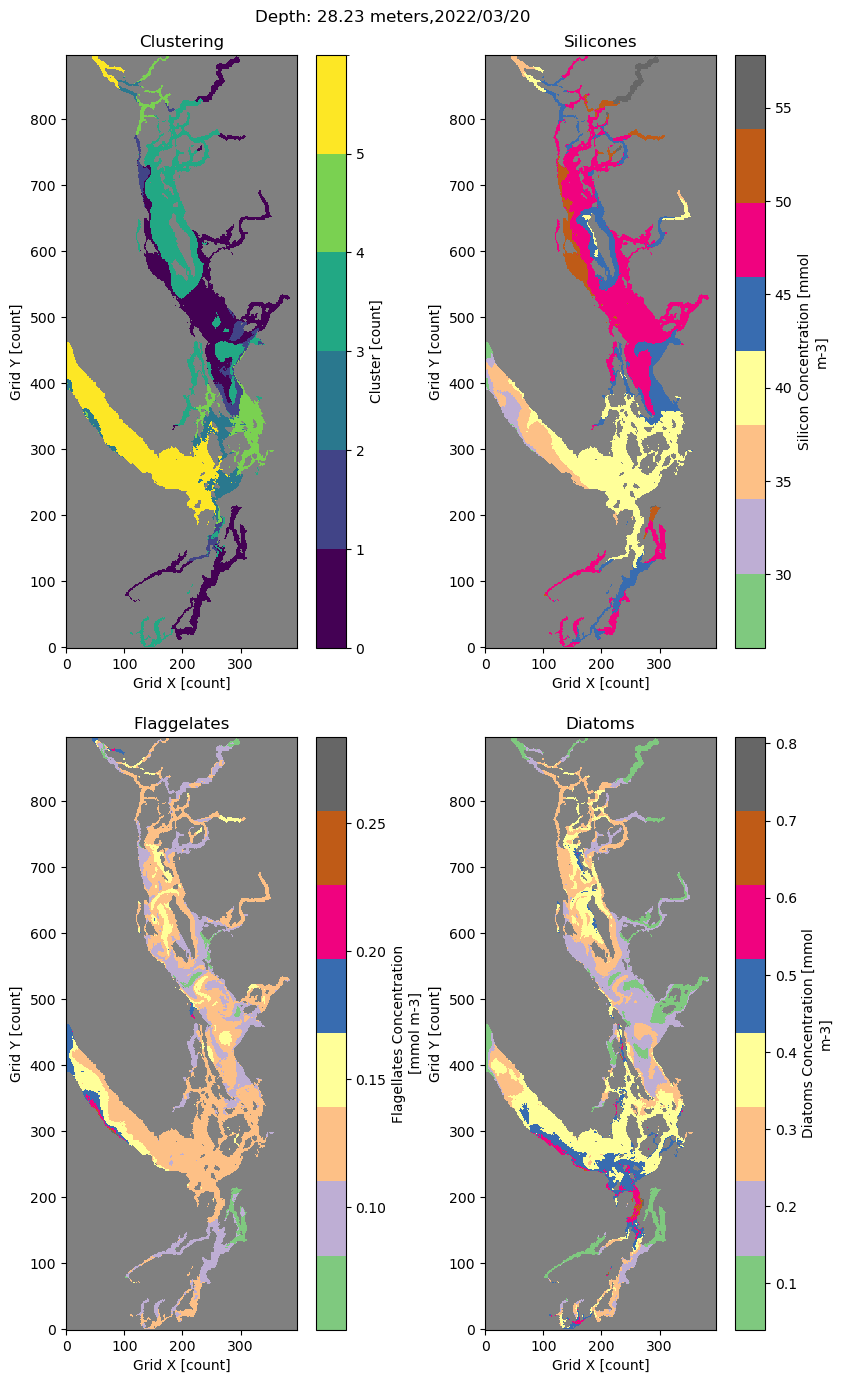

The amount of grid boxes for cluster 0 is 19650 

The minimum temperature for cluster 0 is 8.21 degrees Celsius
The maximum temperature for cluster 0 is 10.29 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 28.73 g/kg
The maximum salinity for cluster 0 is 29.92 g/kg
The mean salinity for cluster 0 is 29.61 g/kg 


The amount of grid boxes for cluster 1 is 1496 

The minimum temperature for cluster 1 is 7.66 degrees Celsius
The maximum temperature for cluster 1 is 8.45 degrees Celsius
The mean temperature for cluster 1 is 8.05 degrees Celsius 

The minimum salinity for cluster 1 is 29.71 g/kg
The maximum salinity for cluster 1 is 30.14 g/kg
The mean salinity for cluster 1 is 29.93 g/kg 


The amount of grid boxes for cluster 2 is 15355 

The minimum temperature for cluster 2 is 6.99 degrees Celsius
The maximum temperature for cluster 2 is 7.99 degrees Celsius
The mean temperature for cluster 2 is 7.61 degrees Celsius 

T

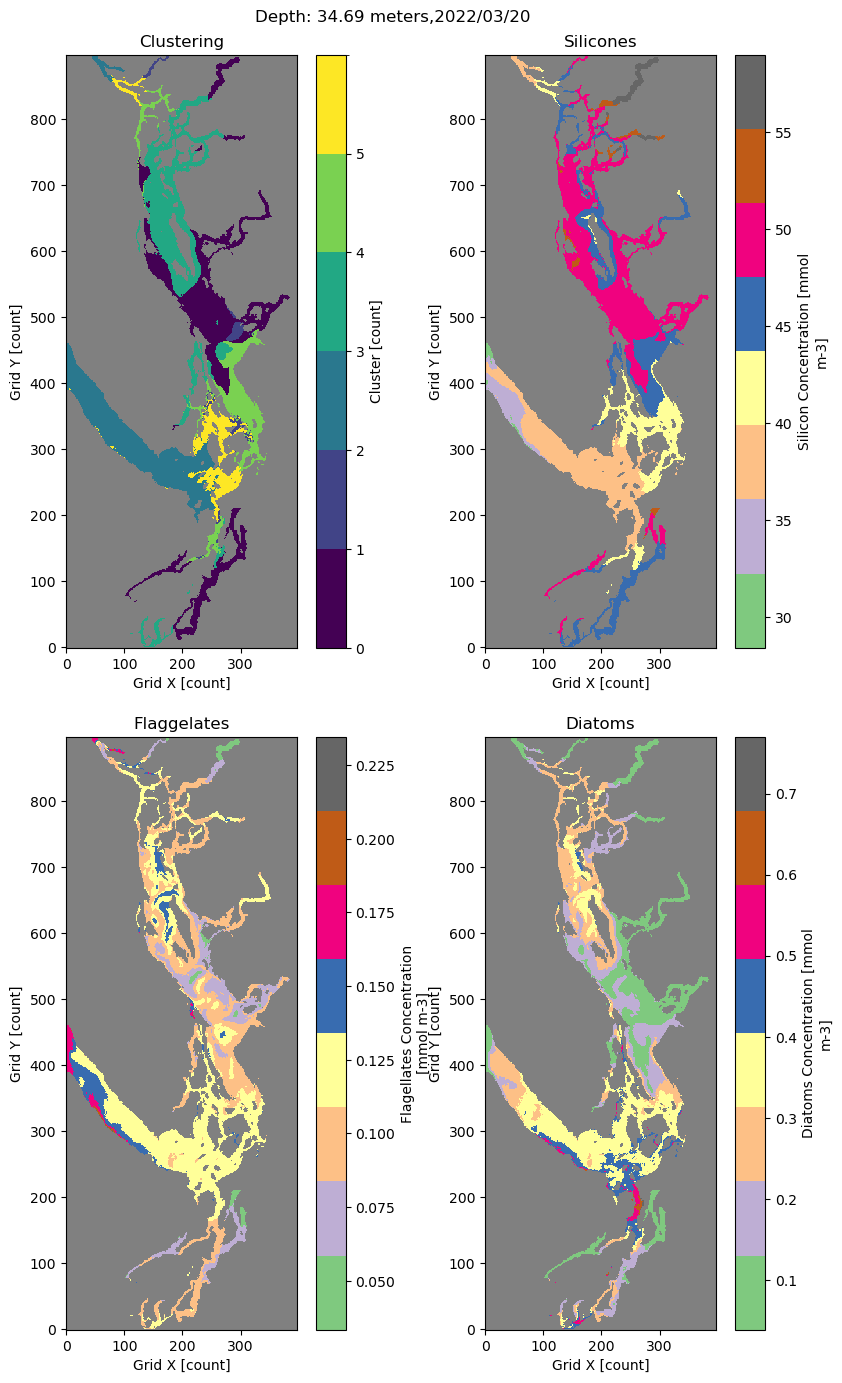

The amount of grid boxes for cluster 0 is 19247 

The minimum temperature for cluster 0 is 8.24 degrees Celsius
The maximum temperature for cluster 0 is 10.33 degrees Celsius
The mean temperature for cluster 0 is 8.73 degrees Celsius 

The minimum salinity for cluster 0 is 29.32 g/kg
The maximum salinity for cluster 0 is 30.29 g/kg
The mean salinity for cluster 0 is 29.76 g/kg 


The amount of grid boxes for cluster 1 is 1040 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.91 g/kg
The maximum salinity for cluster 1 is 30.28 g/kg
The mean salinity for cluster 1 is 30.12 g/kg 


The amount of grid boxes for cluster 2 is 14410 

The minimum temperature for cluster 2 is 7.02 degrees Celsius
The maximum temperature for cluster 2 is 7.97 degrees Celsius
The mean temperature for cluster 2 is 7.57 degrees Celsius 

The

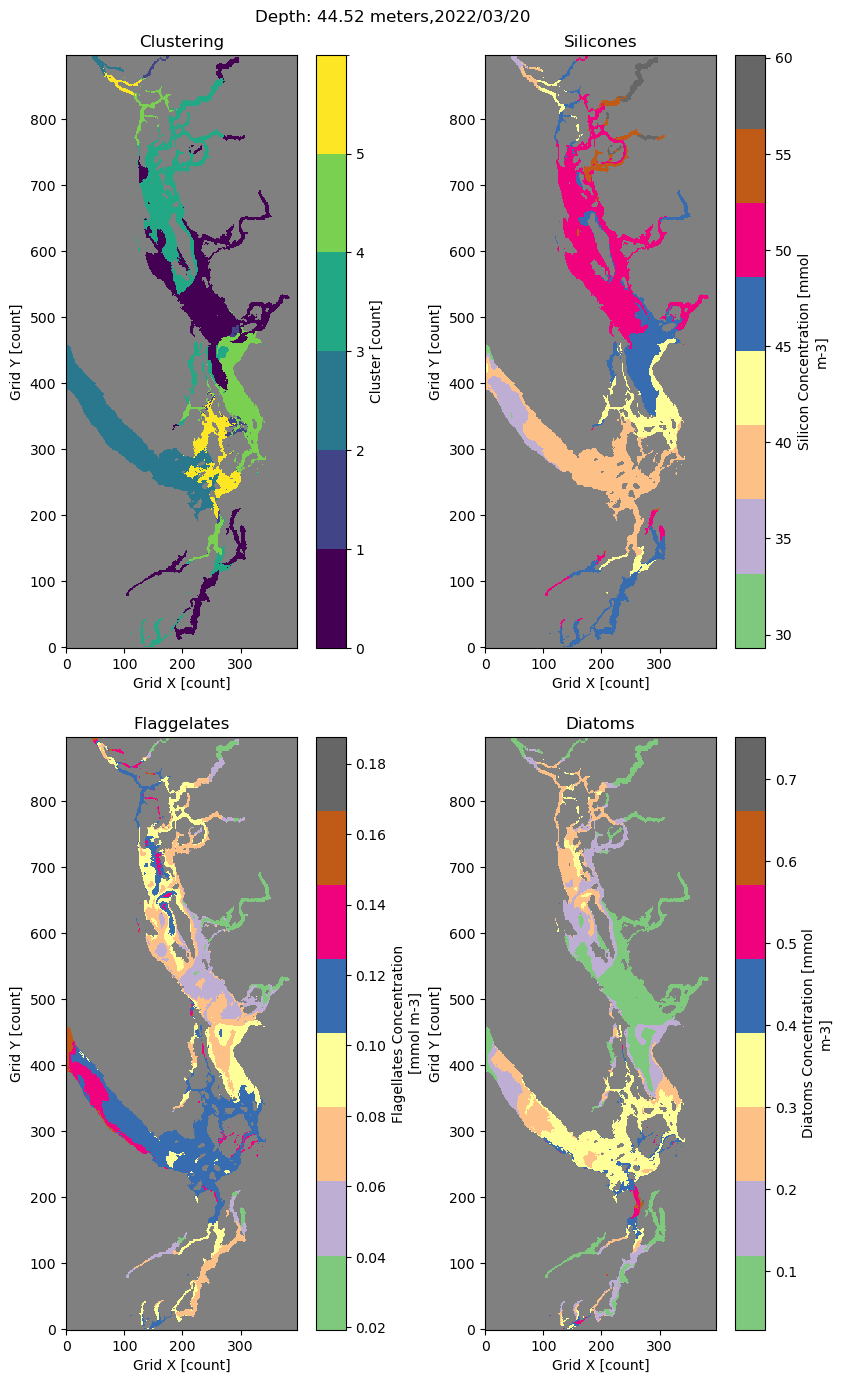

The amount of grid boxes for cluster 0 is 15885 

The minimum temperature for cluster 0 is 7.45 degrees Celsius
The maximum temperature for cluster 0 is 8.63 degrees Celsius
The mean temperature for cluster 0 is 8.32 degrees Celsius 

The minimum salinity for cluster 0 is 27.4 g/kg
The maximum salinity for cluster 0 is 30.09 g/kg
The mean salinity for cluster 0 is 29.61 g/kg 


The amount of grid boxes for cluster 1 is 10313 

The minimum temperature for cluster 1 is 7.3 degrees Celsius
The maximum temperature for cluster 1 is 8.33 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 30.41 g/kg
The mean salinity for cluster 1 is 29.96 g/kg 


The amount of grid boxes for cluster 2 is 4949 

The minimum temperature for cluster 2 is 7.06 degrees Celsius
The maximum temperature for cluster 2 is 7.76 degrees Celsius
The mean temperature for cluster 2 is 7.53 degrees Celsius 

The 

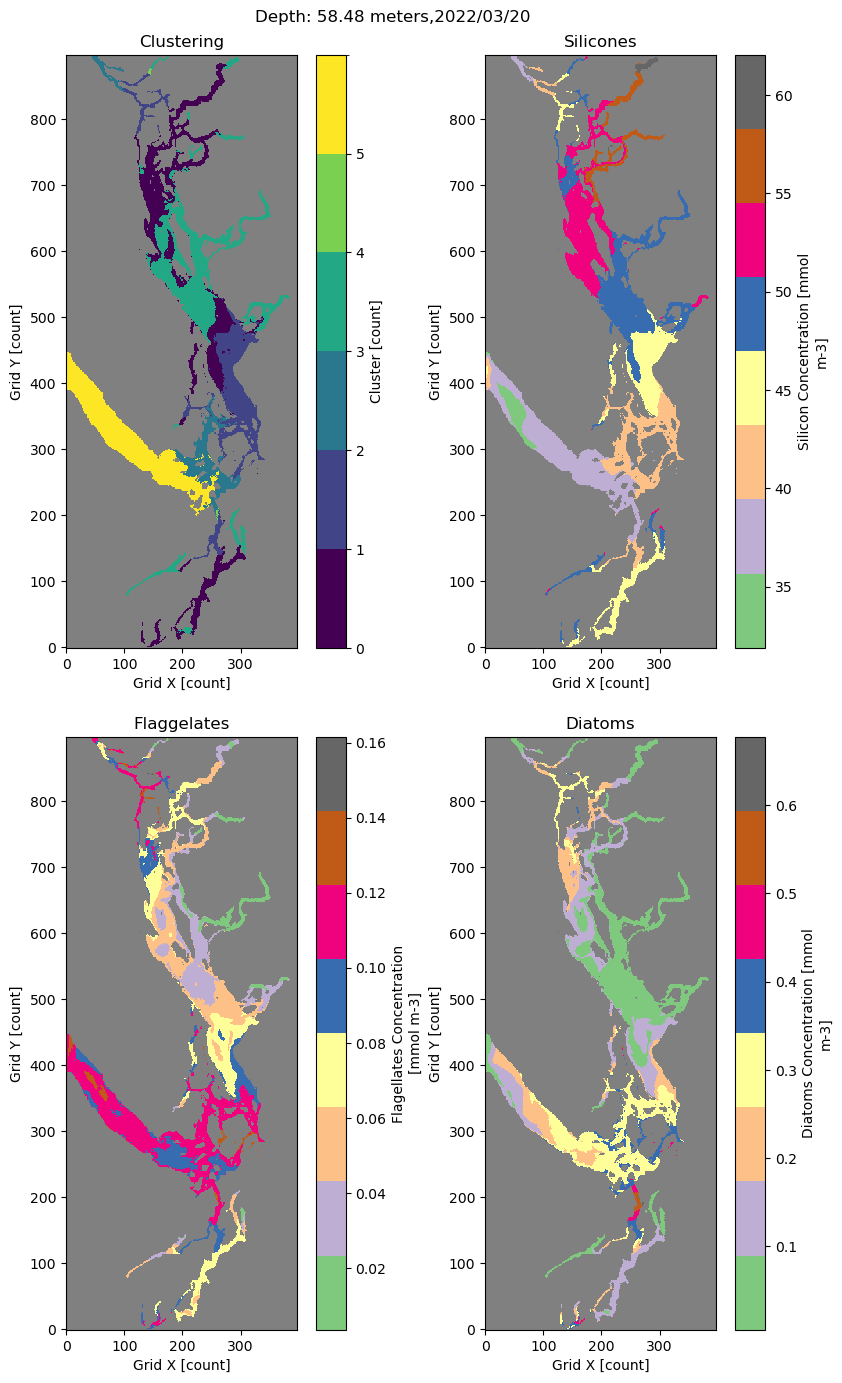

The amount of grid boxes for cluster 0 is 11063 

The minimum temperature for cluster 0 is 7.45 degrees Celsius
The maximum temperature for cluster 0 is 8.64 degrees Celsius
The mean temperature for cluster 0 is 8.32 degrees Celsius 

The minimum salinity for cluster 0 is 27.46 g/kg
The maximum salinity for cluster 0 is 30.31 g/kg
The mean salinity for cluster 0 is 29.79 g/kg 


The amount of grid boxes for cluster 1 is 10097 

The minimum temperature for cluster 1 is 7.3 degrees Celsius
The maximum temperature for cluster 1 is 8.35 degrees Celsius
The mean temperature for cluster 1 is 7.82 degrees Celsius 

The minimum salinity for cluster 1 is 29.22 g/kg
The maximum salinity for cluster 1 is 30.57 g/kg
The mean salinity for cluster 1 is 30.07 g/kg 


The amount of grid boxes for cluster 2 is 3536 

The minimum temperature for cluster 2 is 7.18 degrees Celsius
The maximum temperature for cluster 2 is 7.7 degrees Celsius
The mean temperature for cluster 2 is 7.5 degrees Celsius 

The m

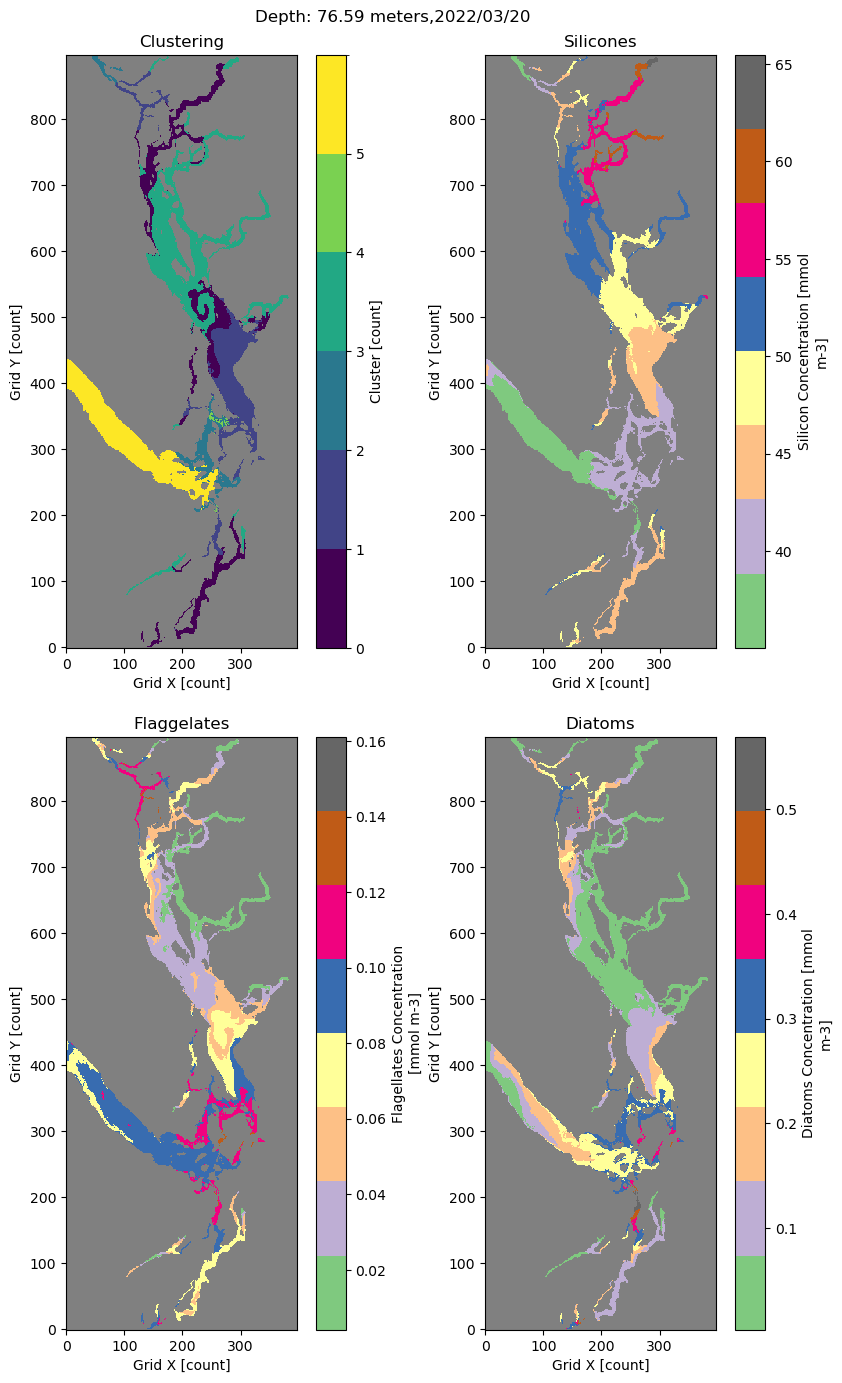

The amount of grid boxes for cluster 0 is 16346 

The minimum temperature for cluster 0 is 8.54 degrees Celsius
The maximum temperature for cluster 0 is 10.69 degrees Celsius
The mean temperature for cluster 0 is 8.95 degrees Celsius 

The minimum salinity for cluster 0 is 29.74 g/kg
The maximum salinity for cluster 0 is 30.55 g/kg
The mean salinity for cluster 0 is 30.17 g/kg 


The amount of grid boxes for cluster 2 is 9557 

The minimum temperature for cluster 2 is 7.16 degrees Celsius
The maximum temperature for cluster 2 is 7.43 degrees Celsius
The mean temperature for cluster 2 is 7.3 degrees Celsius 

The minimum salinity for cluster 2 is 31.95 g/kg
The maximum salinity for cluster 2 is 33.25 g/kg
The mean salinity for cluster 2 is 32.77 g/kg 


The amount of grid boxes for cluster 3 is 8405 

The minimum temperature for cluster 3 is 7.46 degrees Celsius
The maximum temperature for cluster 3 is 8.61 degrees Celsius
The mean temperature for cluster 3 is 8.23 degrees Celsius 

The

IndexError: index 5 is out of bounds for axis 0 with size 5

In [21]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)
